# Time Series EDA - Users and Real Sessions
In Kaggle's Otto competition the word "session" actually means "user". In this notebook, we display users and their real sessions time series EDA. We observe that users exhibit regular patterns of session behavior. These observations can help us characterize and engineer features for users. These observations can also give us insight into predicting future `click`, `cart`, and `order` behavior. We will use `RAPIDS cuDF` to process dataframes and `matplotlib` to display EDA. There is a Kaggle discussion about this notebook [here][1]

[1]: https://www.kaggle.com/competitions/otto-recommender-system/discussion/366138

# Load Libraries and Train Data

In [1]:
# LOAD LIBRARIES
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cudf, cupy
print('Using RAPIDS version',cudf.__version__)

Using RAPIDS version 21.10.01


In [2]:
# LOAD TRAIN DATA. RANDOM SAMPLE 10%
train = cudf.read_parquet('../input/otto-full-optimized-memory-footprint/train.parquet')
sessions = train.session.unique()
sample = cupy.random.choice(sessions,len(sessions)//10,replace=False)
train = train.loc[train.session.isin(sample)]
print('We are using random 1/10 of users. Truncated train data has shape', train.shape )
train.head()

We are using random 1/10 of users. Truncated train data has shape (21668271, 4)


session      aid          ts  type
2234       24  1832623  1659304800     0
2235       24   787236  1659304810     0
2236       24  1832623  1659741574     0
2237       24   100910  1659741664     0
2238       24  1832623  1659741683     0

In [3]:
# MIN AND MAX TRAIN DATES
# IF USING ORIGINAL CSV, USE "TS * 1e6" BELOW
train.ts = cudf.to_datetime(train.ts * 1e9)
print('Train min date and max date are:', train.ts.min(),'and', train.ts.max() )
print('We will truncate train data to begin Aug 1st, 2022')
train = train.loc[train.ts >= cudf.to_datetime('2022-08-01')]

Train min date and max date are: 2022-07-31T22:00:00.000000000 and 2022-08-28T21:59:59.000000000
We will truncate train data to begin Aug 1st, 2022


In [4]:
# COMPUTE DAY AND HOUR OF ACTIVITY
train['day'] = train.ts.dt.day
train['hour'] = train.ts.dt.hour
train = train.reset_index(drop=True)
# THE NEXT TWO LINES REPLICATE GROUPBY TRANSFORM
tmp = train.groupby('session').aid.agg('count').rename('n')
train = train.merge(tmp,on='session')
frequent_users = cupy.asnumpy( train.loc[train.n>40,'session'].unique() )
print(f"There are {len(frequent_users)} users whom each have over 40 item interactions in our truncated train data sample.")
print("We will display 128 of these most active users' behavior below.")

There are 123362 users whom each have over 40 item interactions in our truncated train data sample.
We will display 128 of these most active users' behavior below.


# Compute the Real User Sessions
Kaggle's version of RAPIDS cuDF does not contain `groupby` `diff` so we replicate it below. We find real sessions by finding gaps of 2 hours or more between activitiy. Then we label these gaps as `1` and everything else as `0`. Lastly we perform a groupby `cumsum` to locate sessions.

In [5]:
# COMPUTE USER REAL SESSIONS
train.ts = train.ts.astype('int64')/1e9
# THE NEXT THREE LINES REPLICATE GROUPBY DIFF
train = train.sort_values(['session','ts']).reset_index(drop=True)
train['d'] = train.ts.diff()
train.loc[ train.session.diff()!=0, 'd'] = 0
# IDENTITY REAL USER SESSIONS WHEN WE SEE 2 HOUR PAUSE IN ACTIVITY
train.d = (train.d > 60*60*2).astype('int8').fillna(0)
train['d'] = train.groupby('session').d.cumsum()

The mean session count per train user is 4.0 with right skewed distribution below


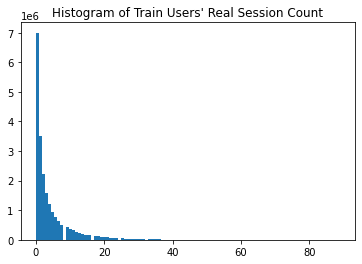

In [6]:
plt.hist(train.d.to_array(), bins=100)
plt.title("Histogram of Train Users' Real Session Count")
m = train.d.mean()
print(f'The mean session count per train user is {m:0.1f} with right skewed distribution below')
plt.show()

# Display User and Sessions Time Series
Below we display a scatter plot with jitter. The x axis is day of the month August 2022. And the y axis is hour of the day. Many dots would fall on top of each other, so we add random x and y jitter. Also we color the `clicks` blue, `carts` orange, and `orders` red. We plot the `clicks` first, then `carts`, then `orders`. This guarentees that the `orders` and `carts` (when present) will always be visible and not be obscured by `click` dots.

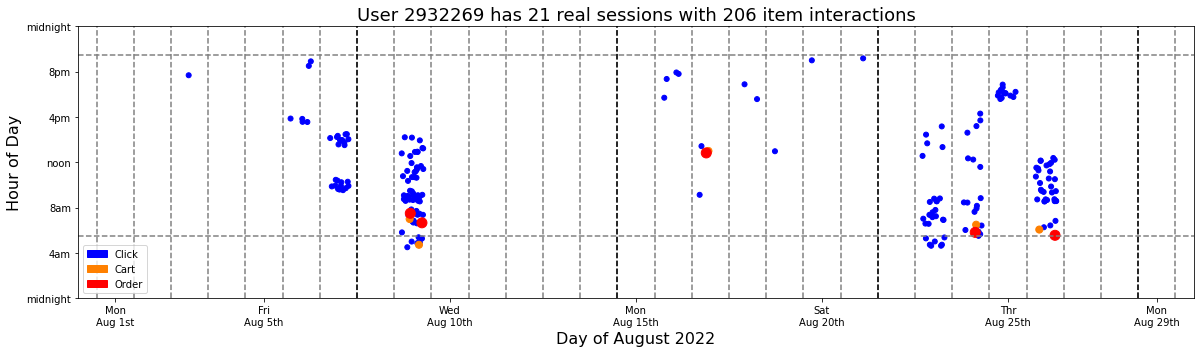

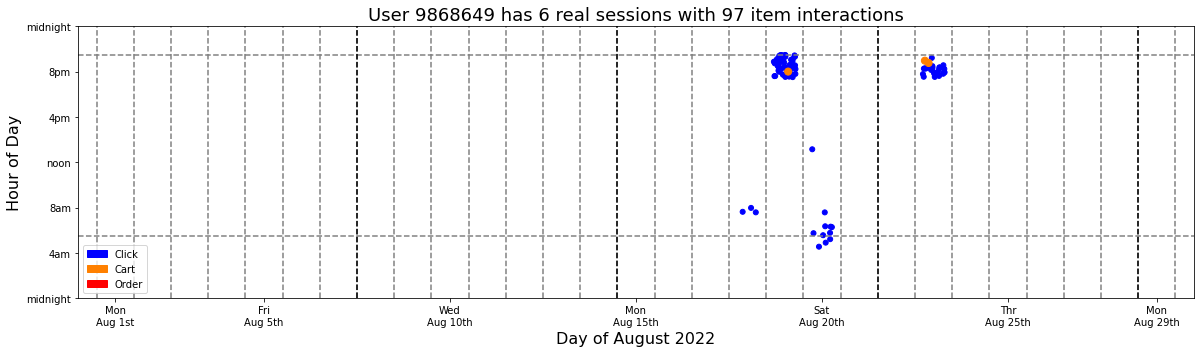

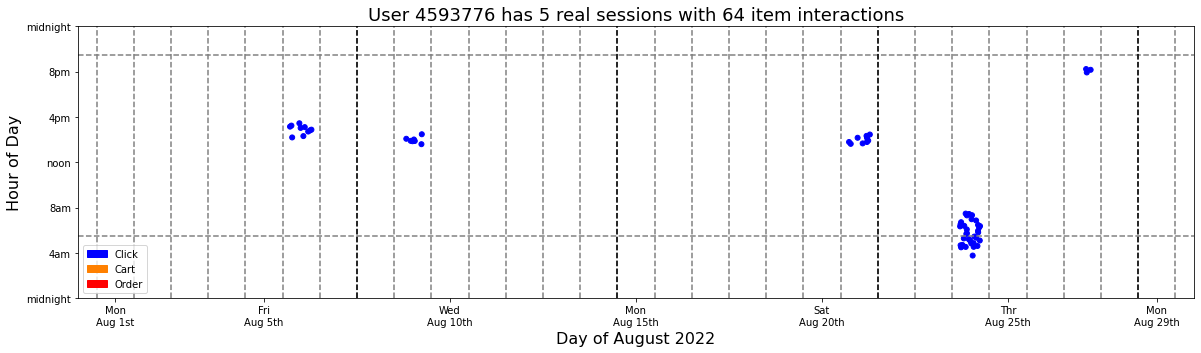

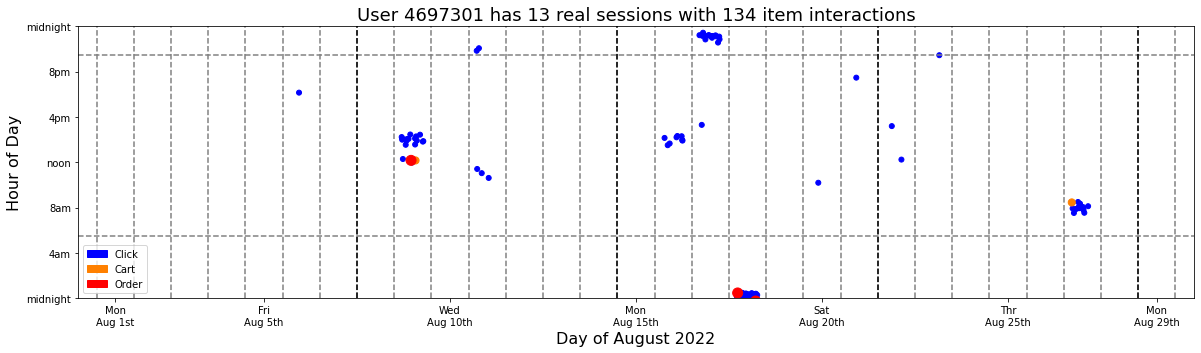

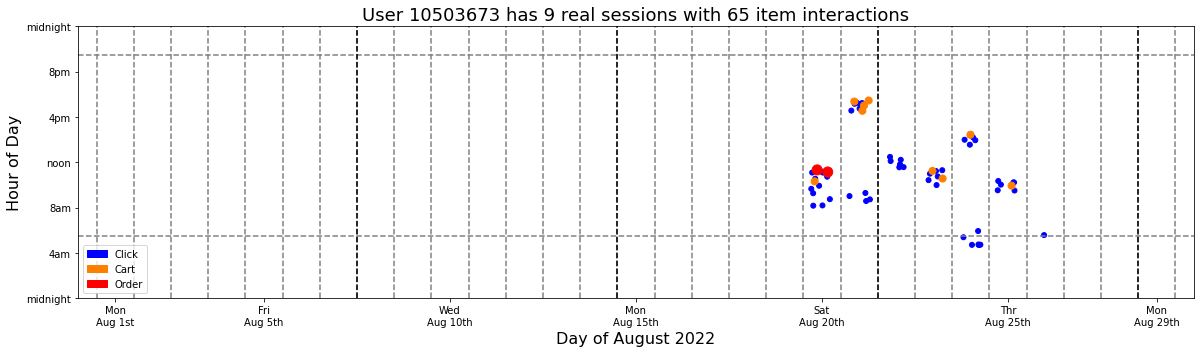

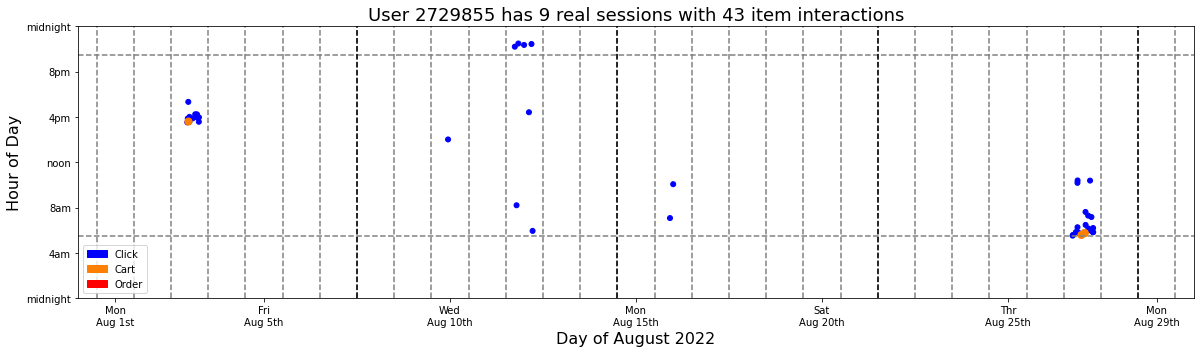

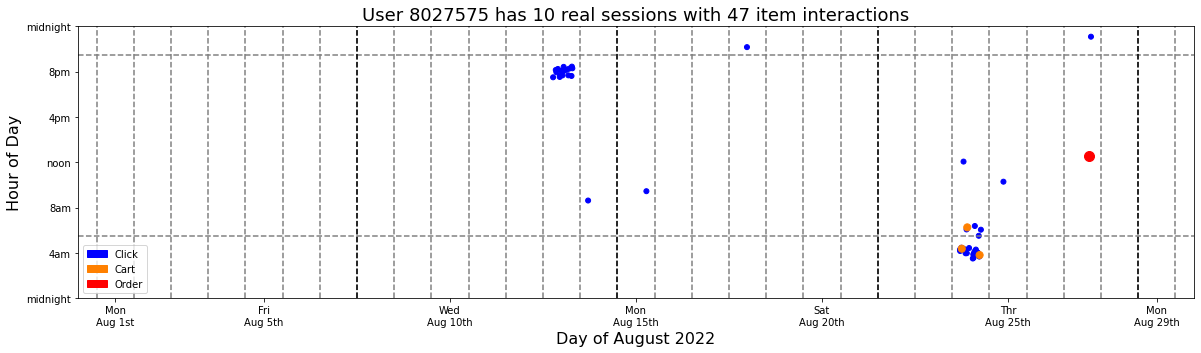

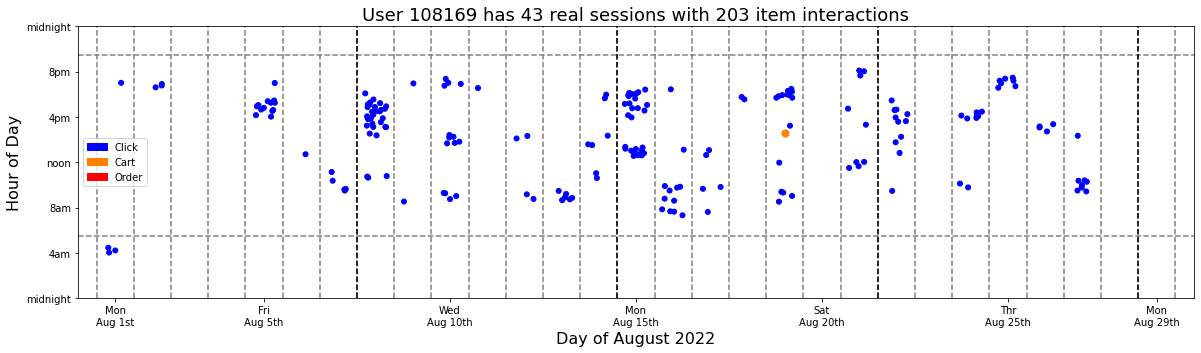

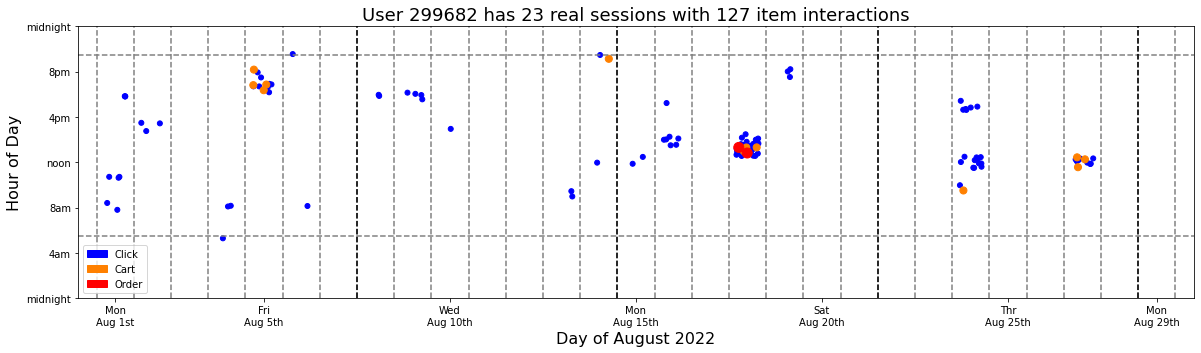

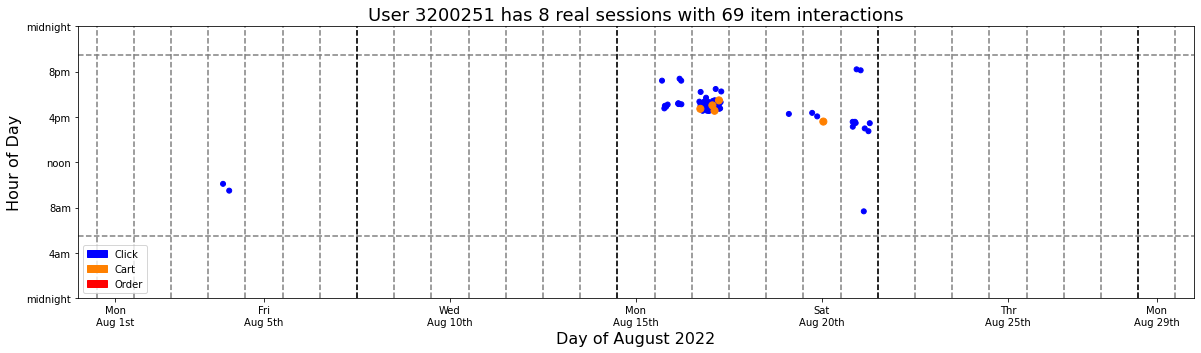

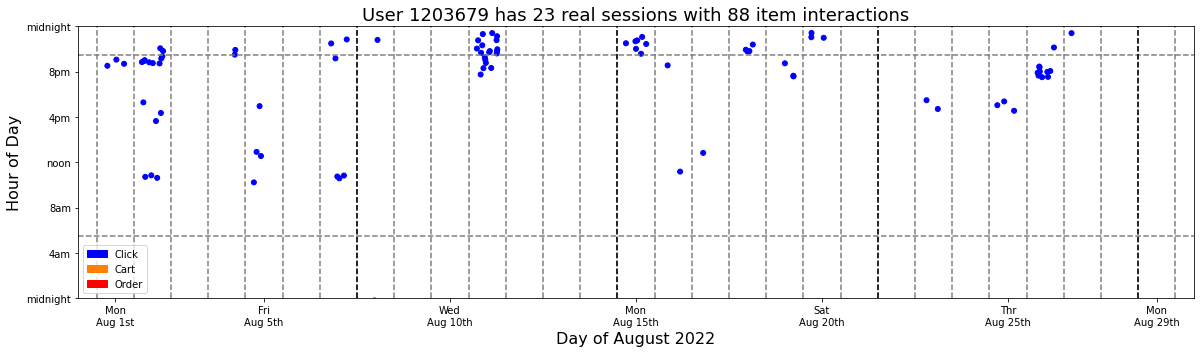

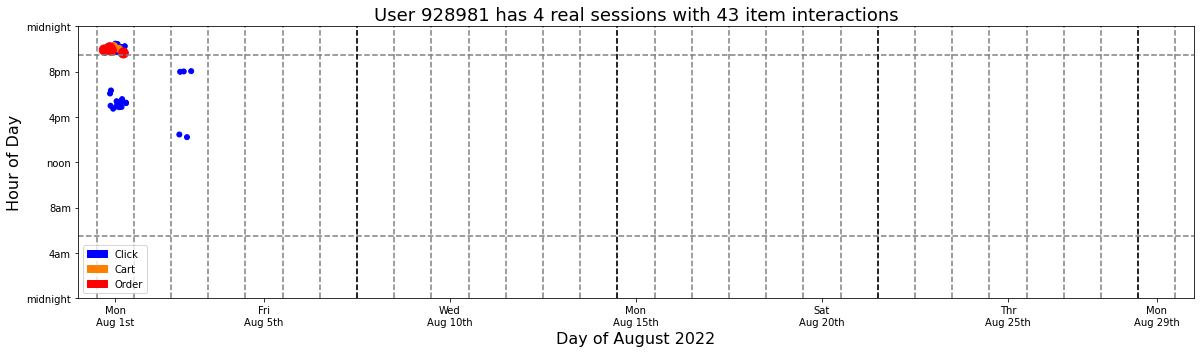

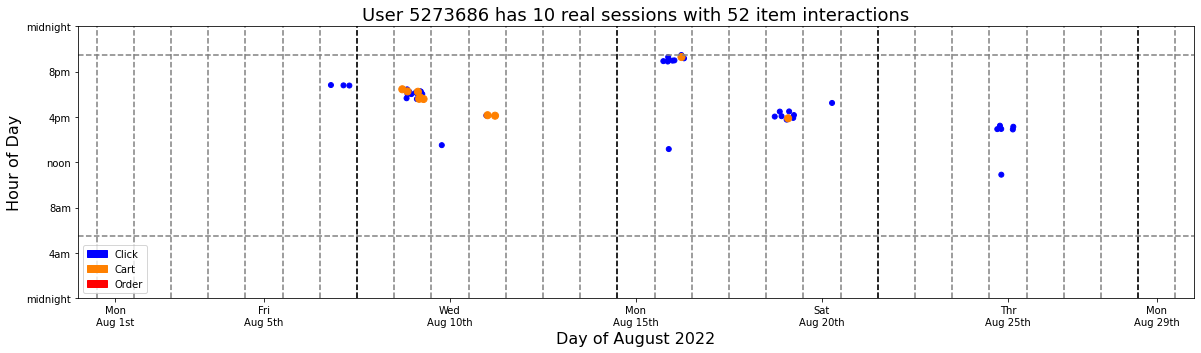

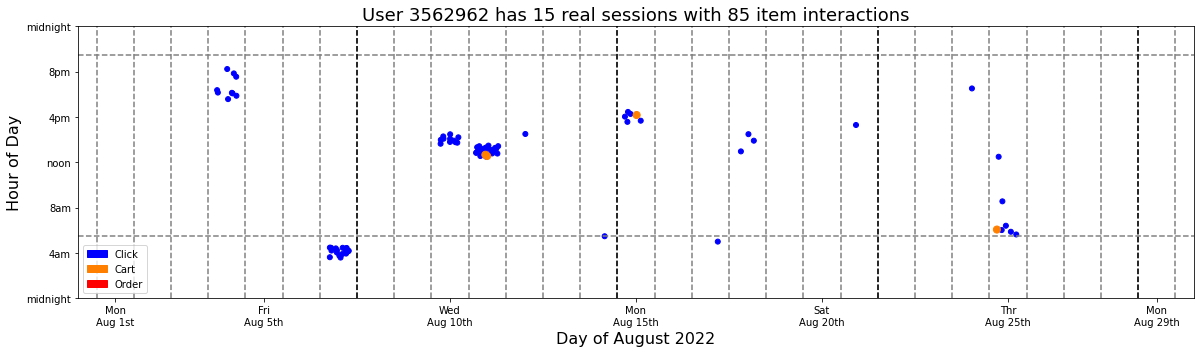

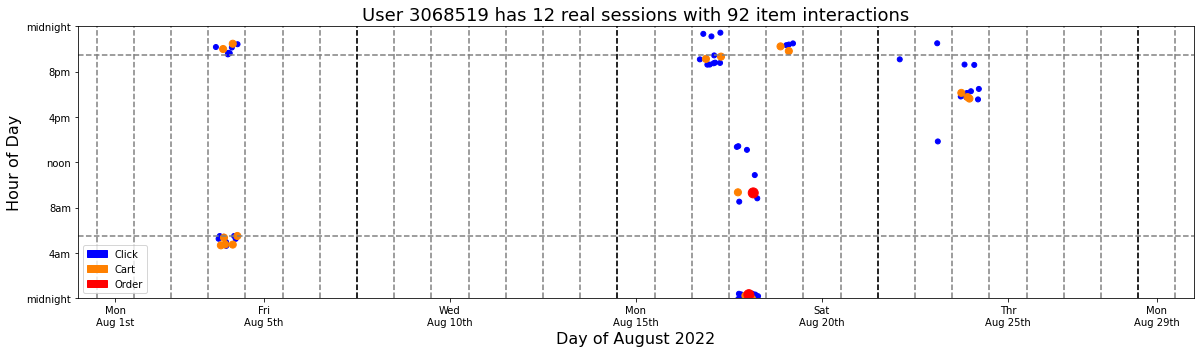

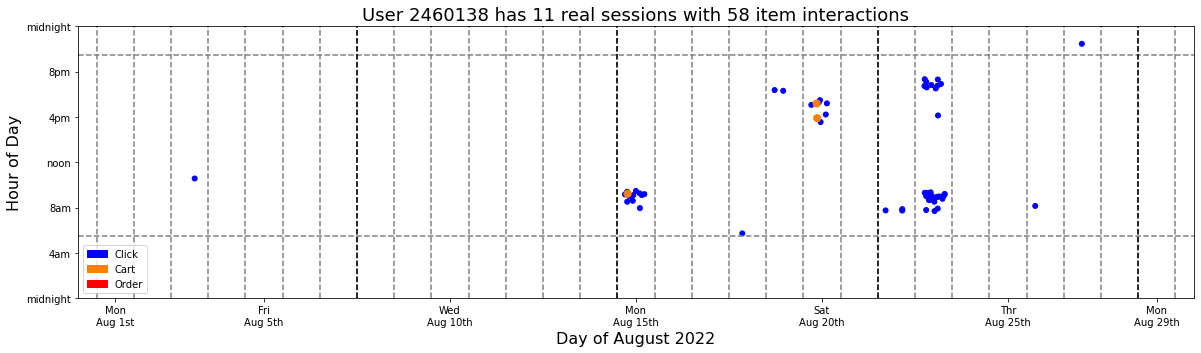

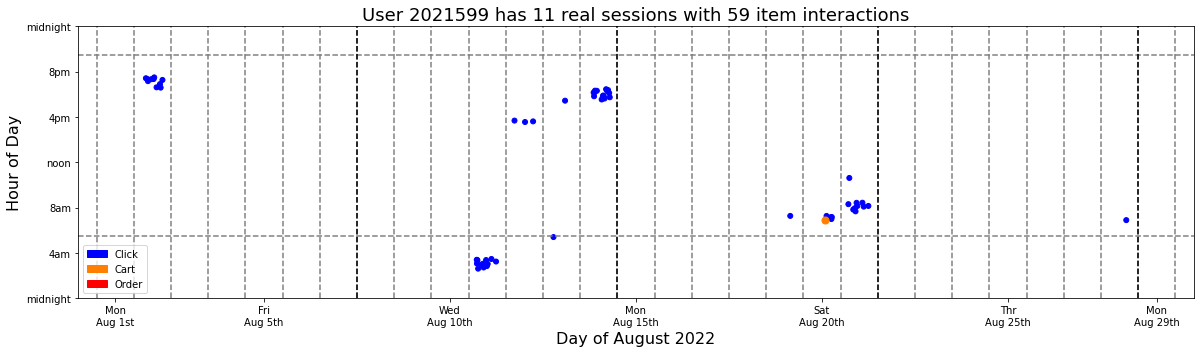

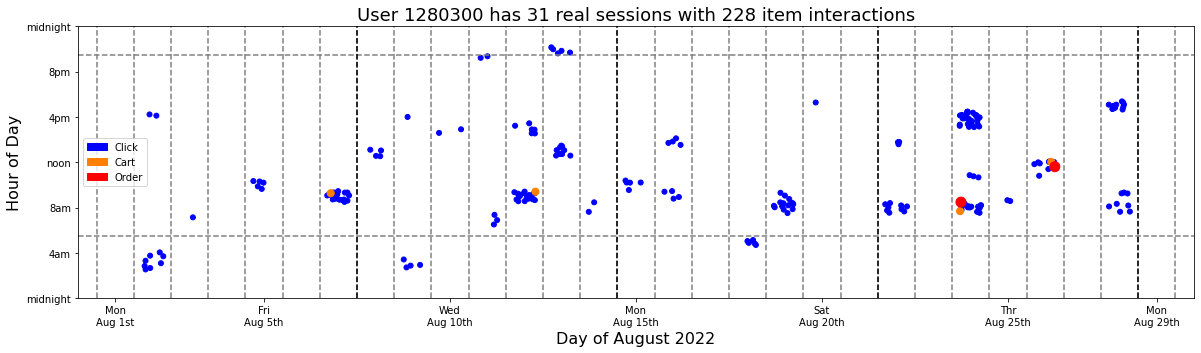

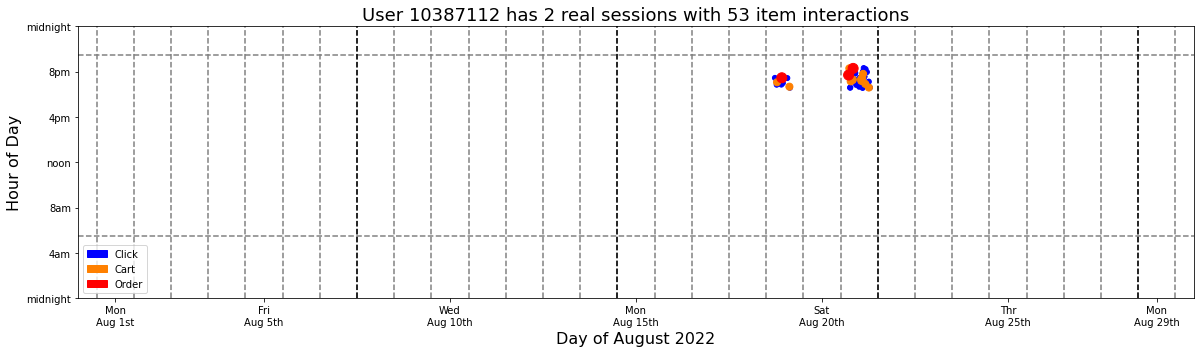

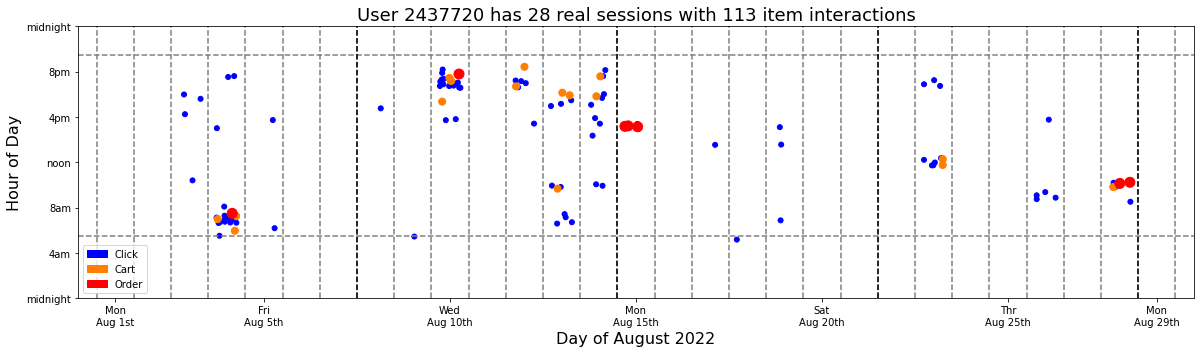

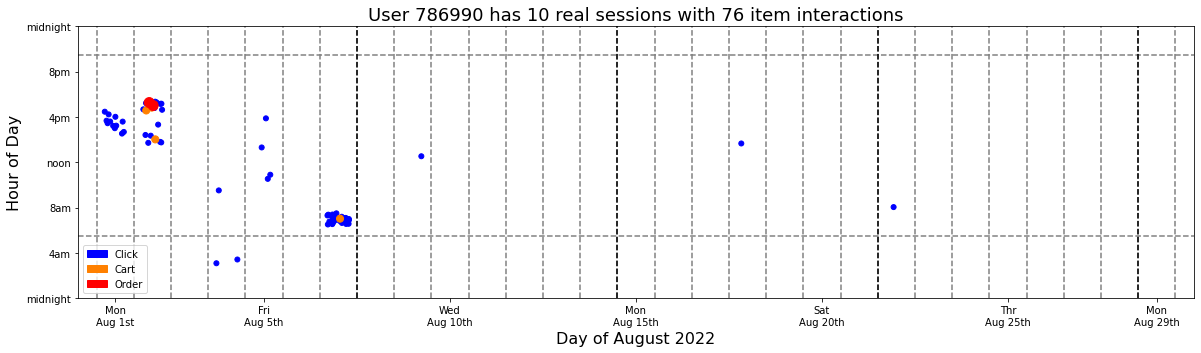

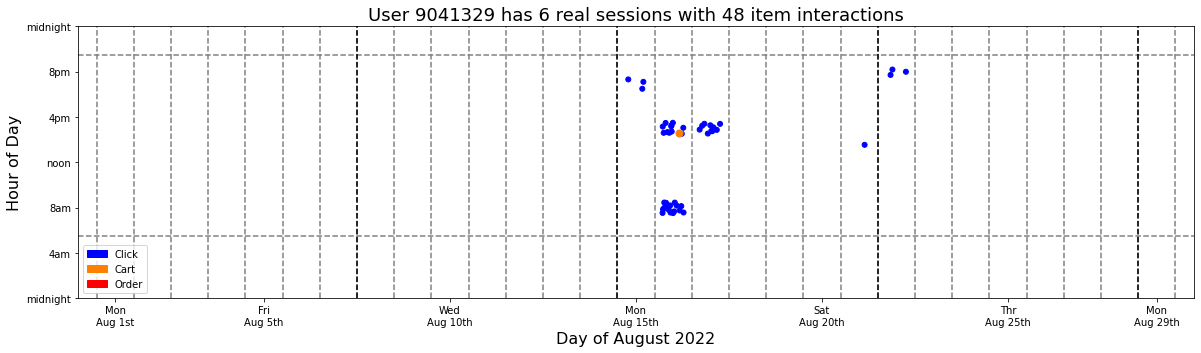

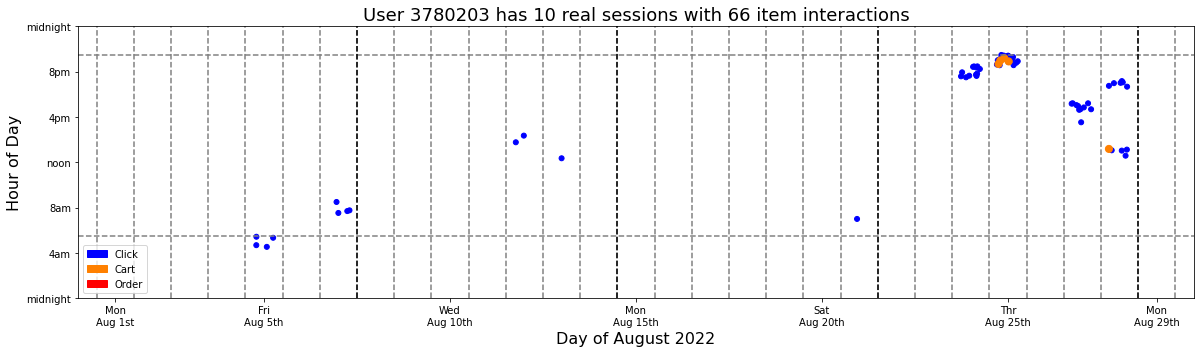

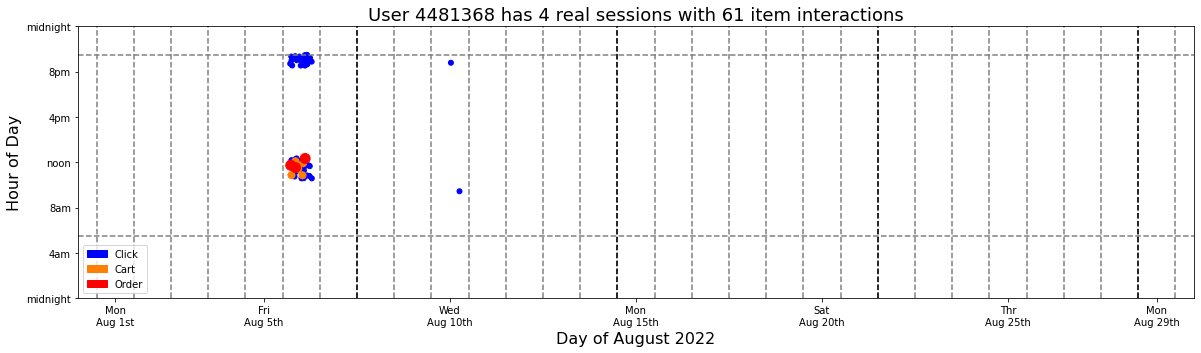

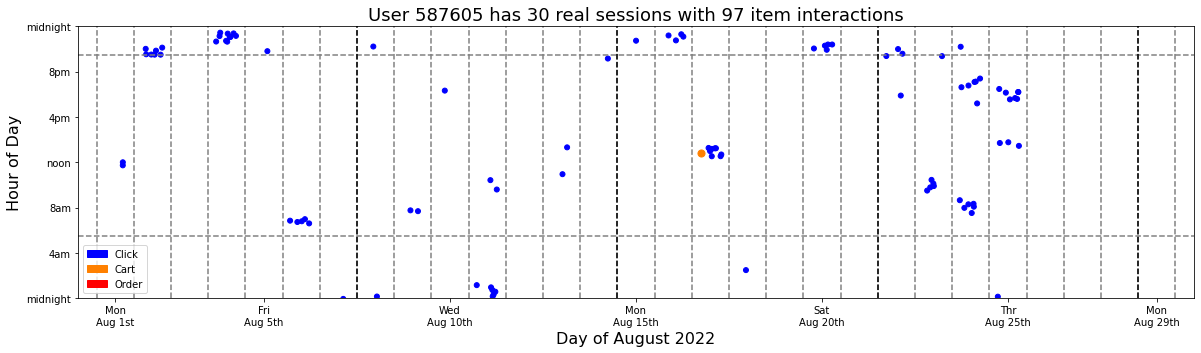

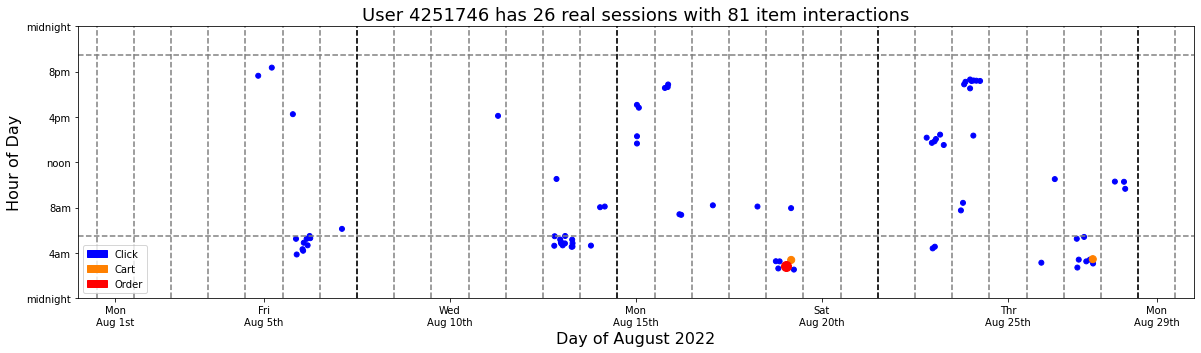

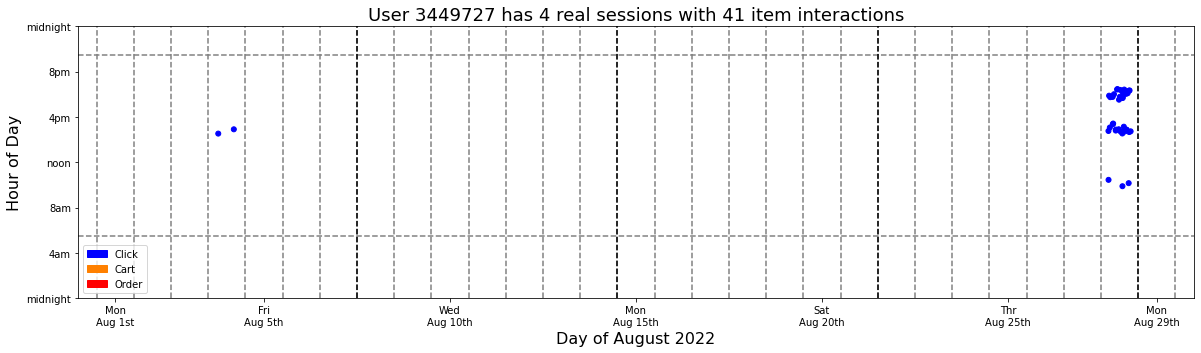

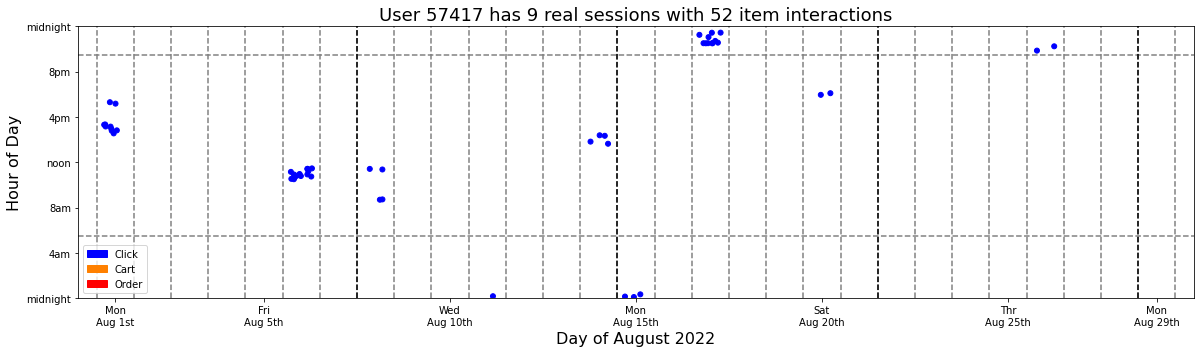

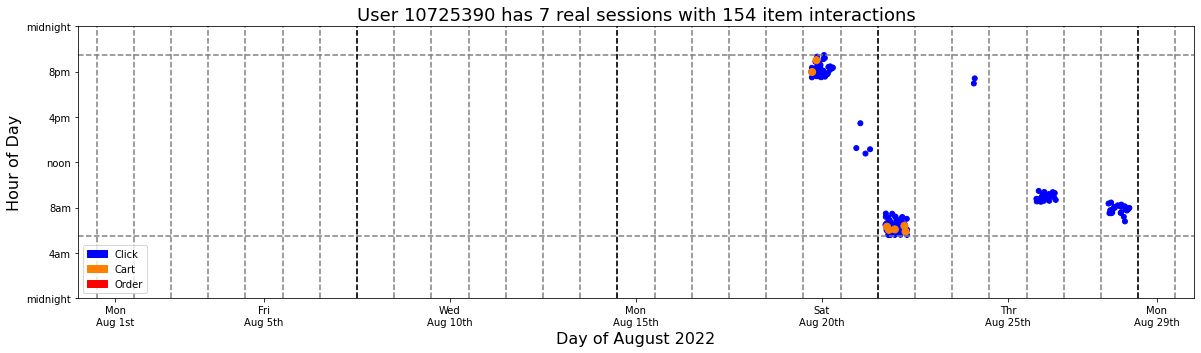

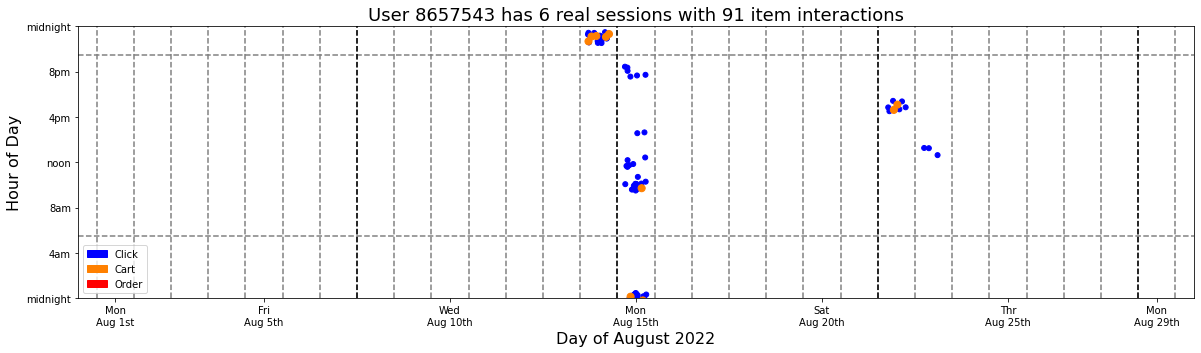

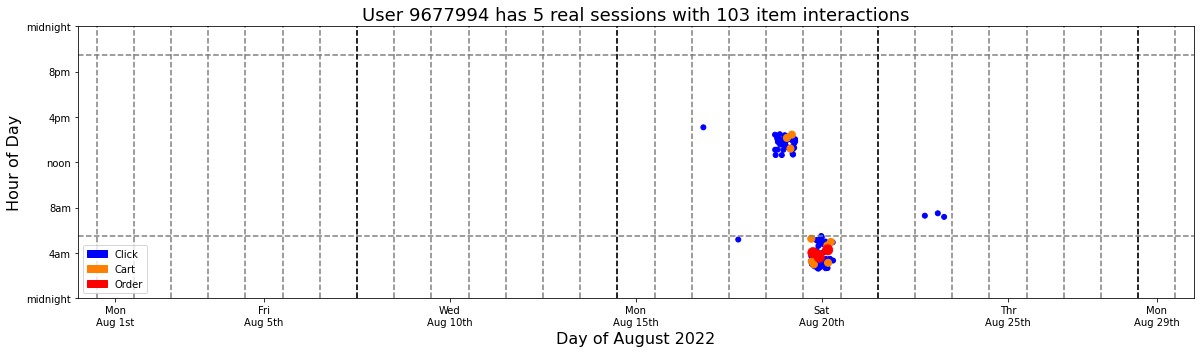

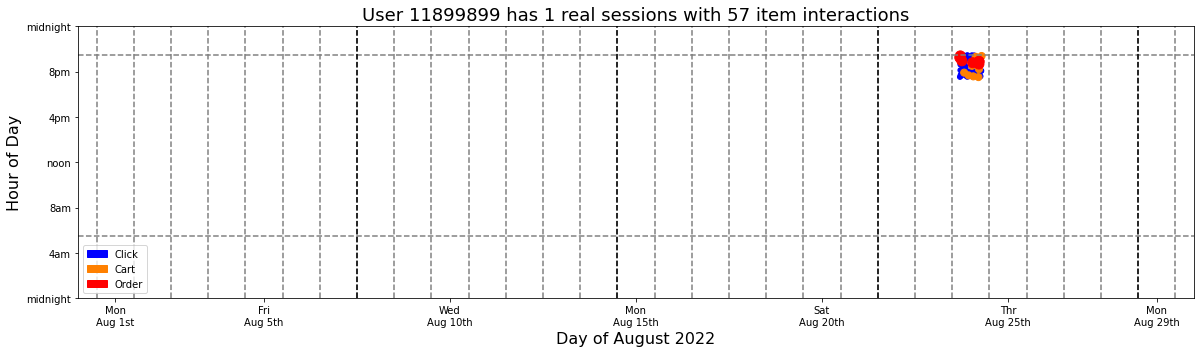

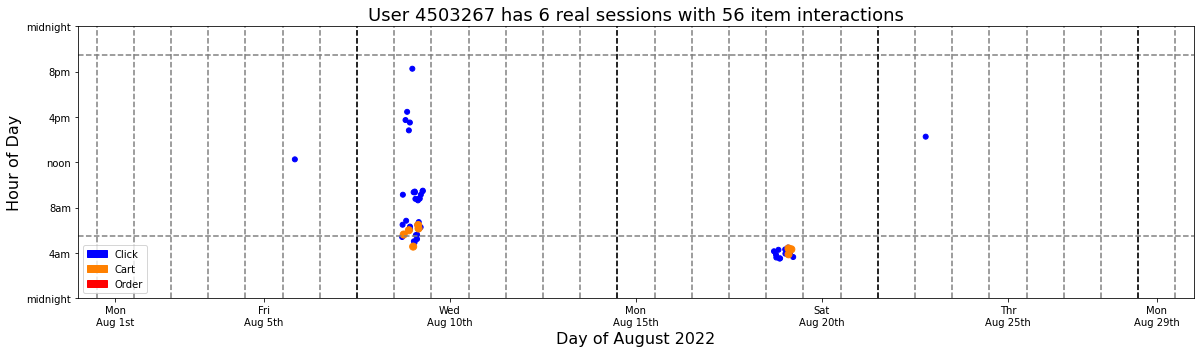

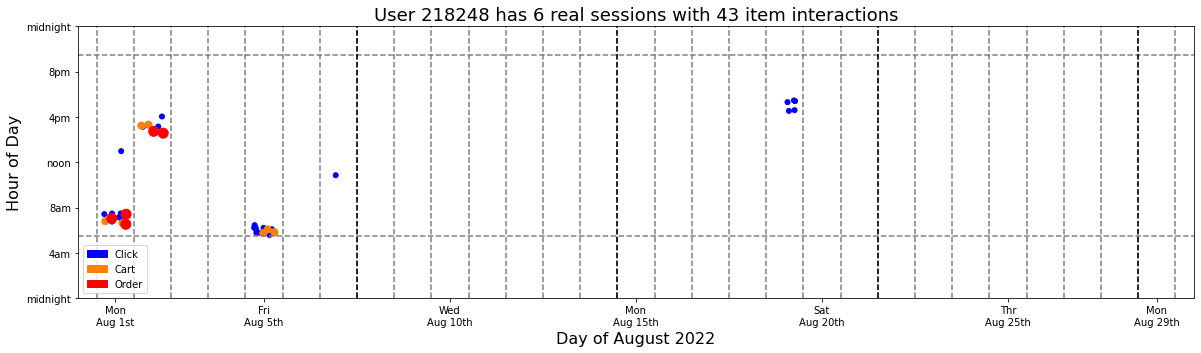

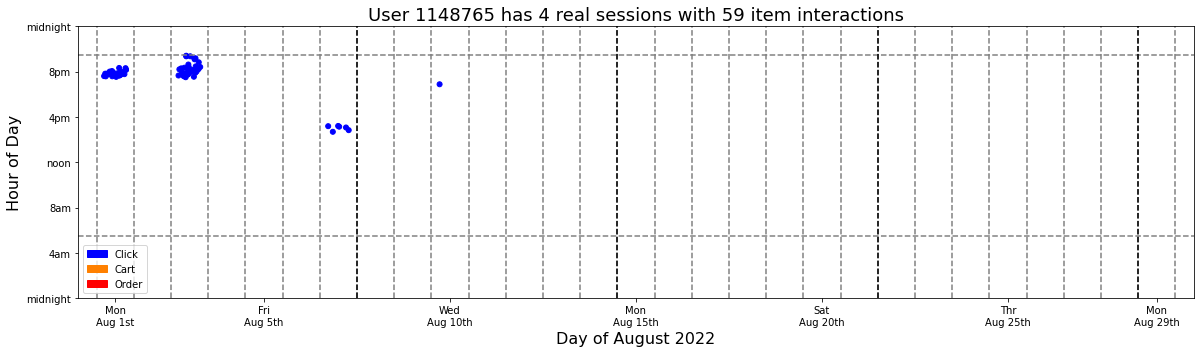

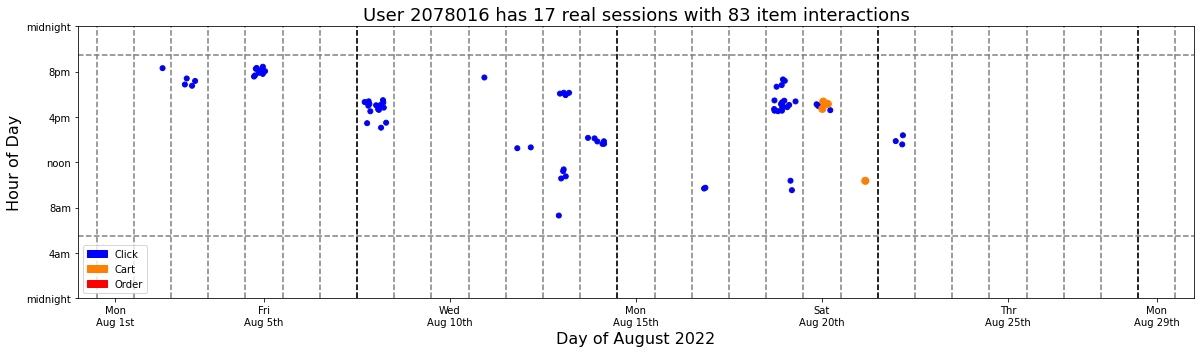

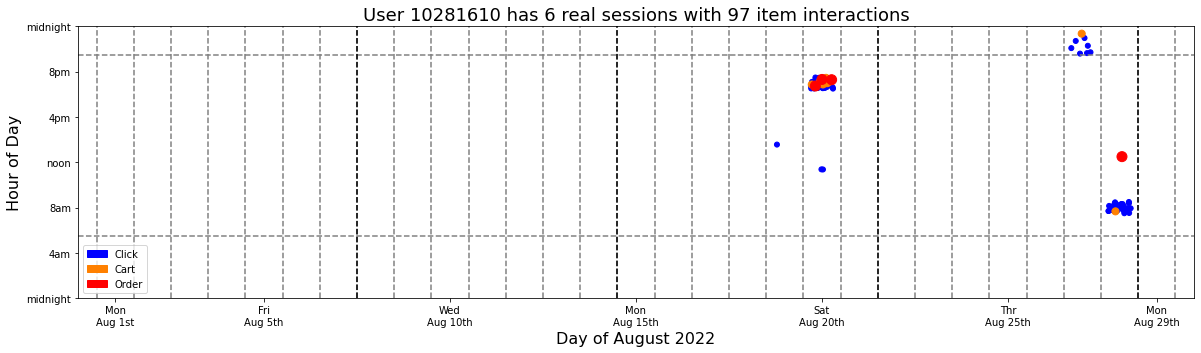

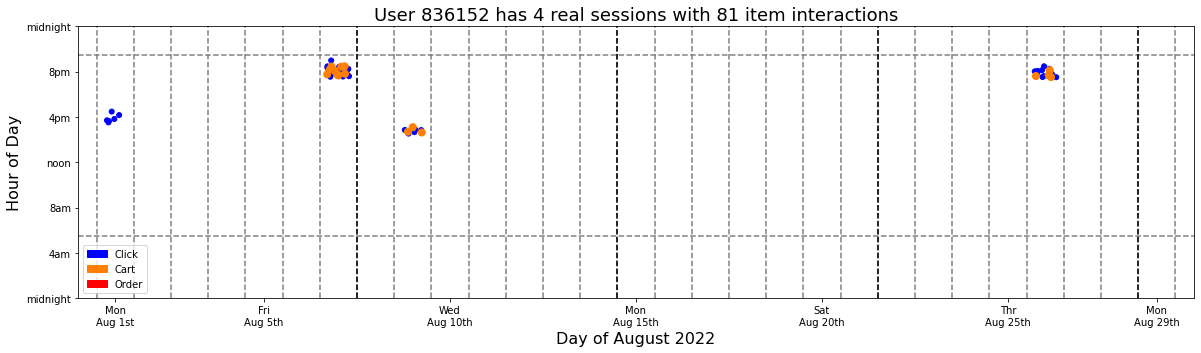

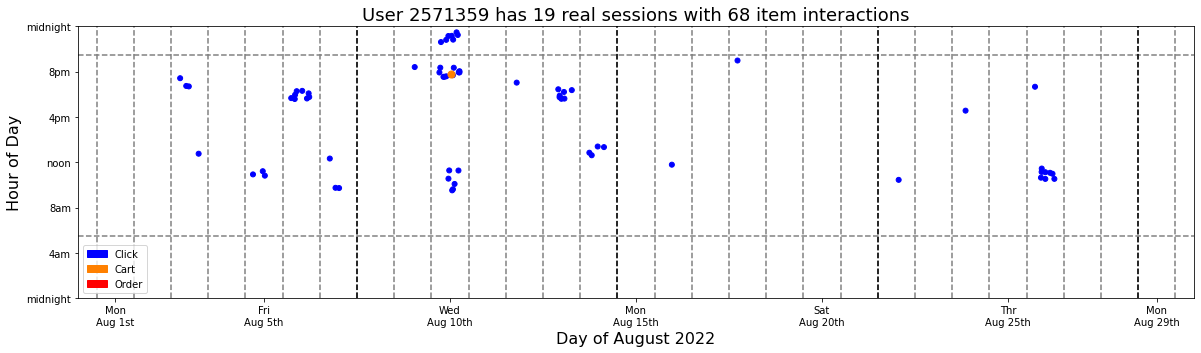

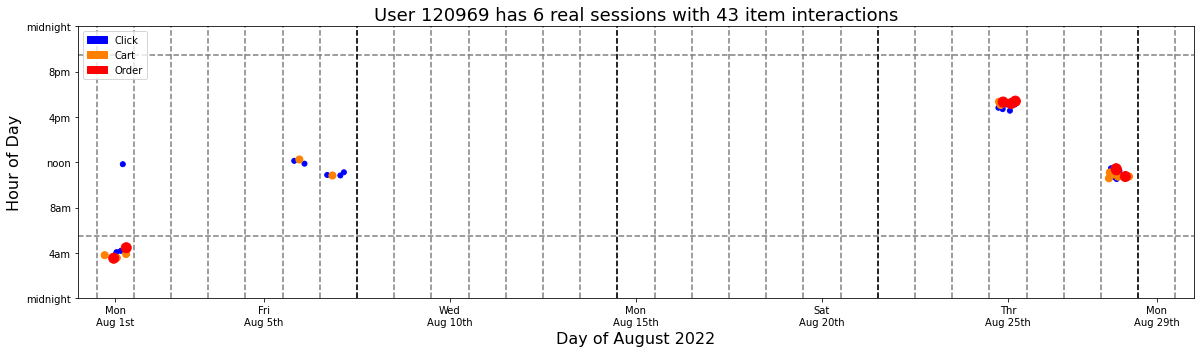

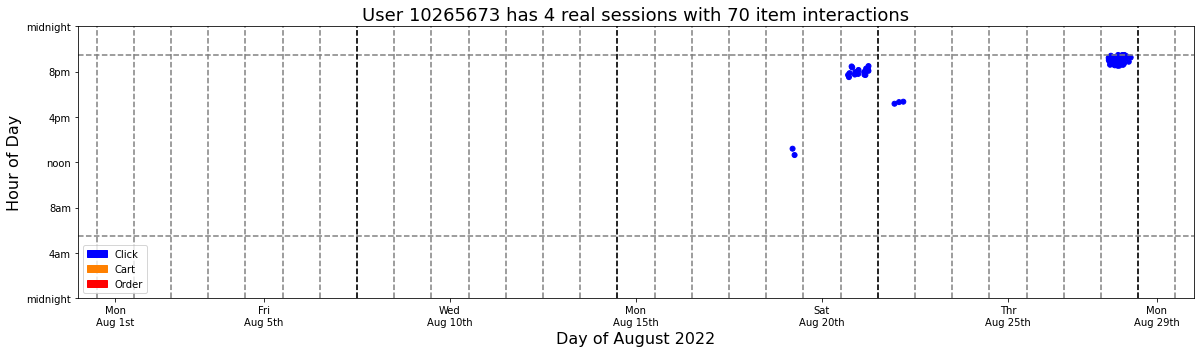

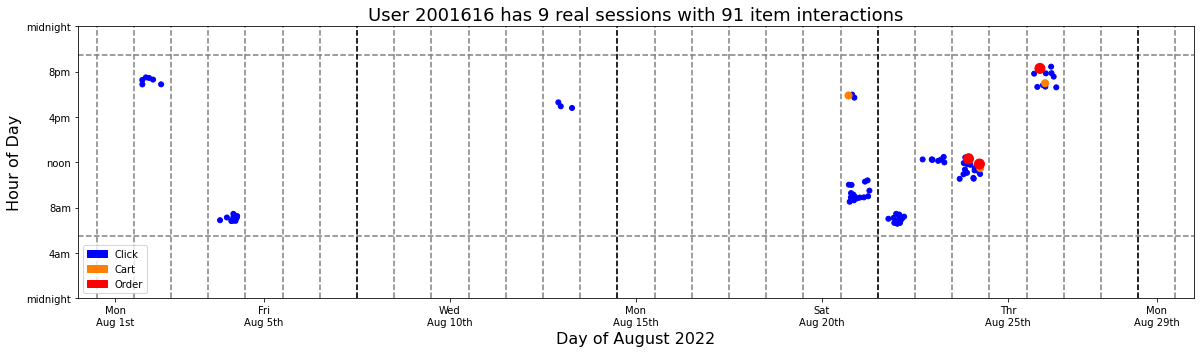

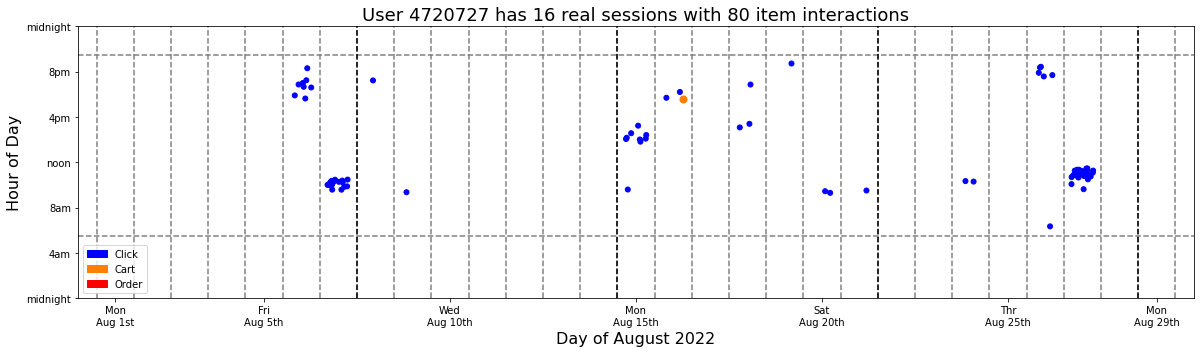

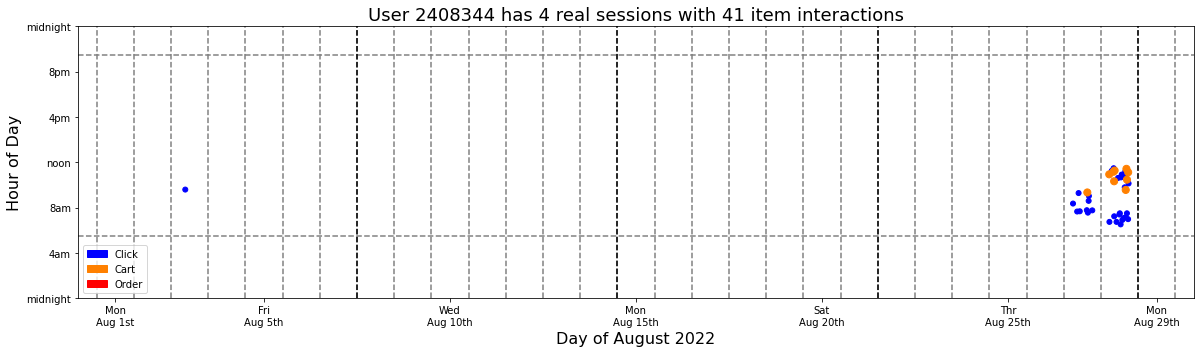

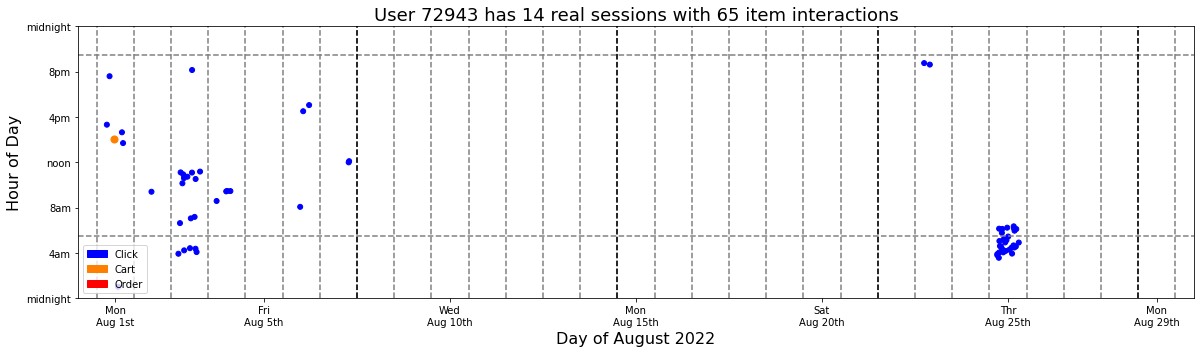

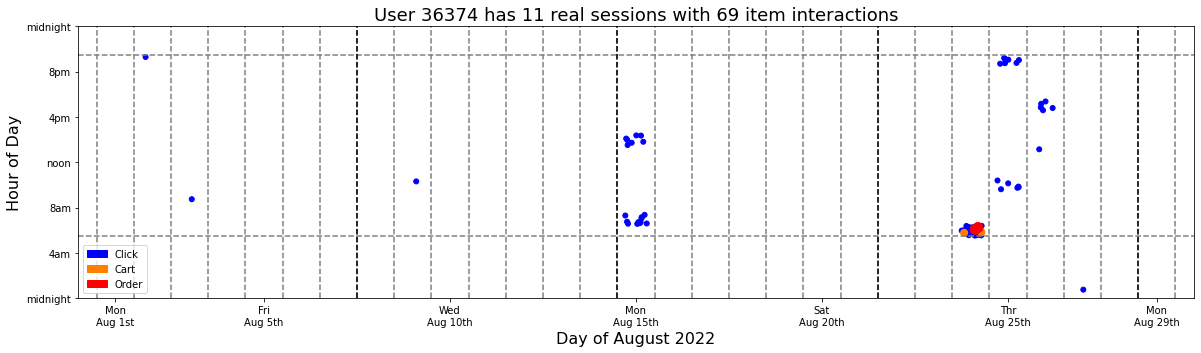

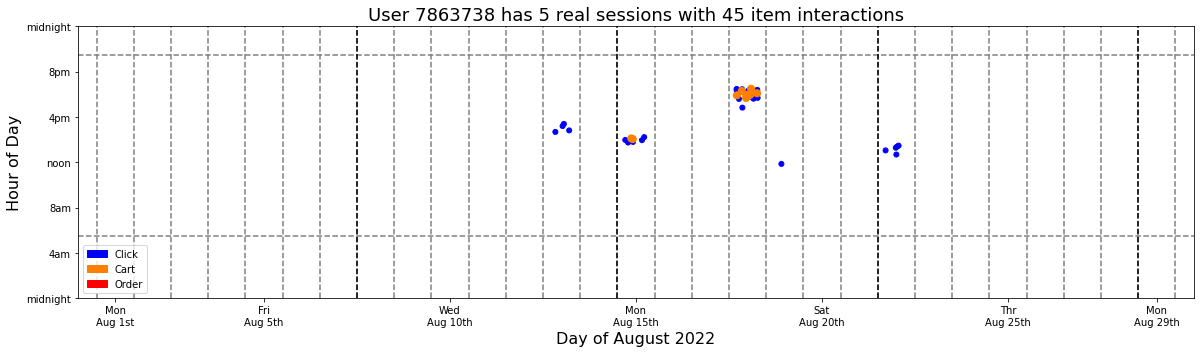

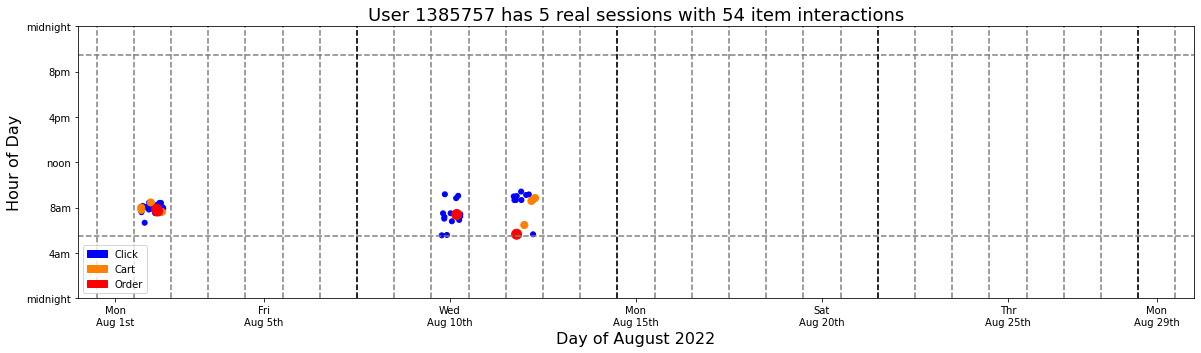

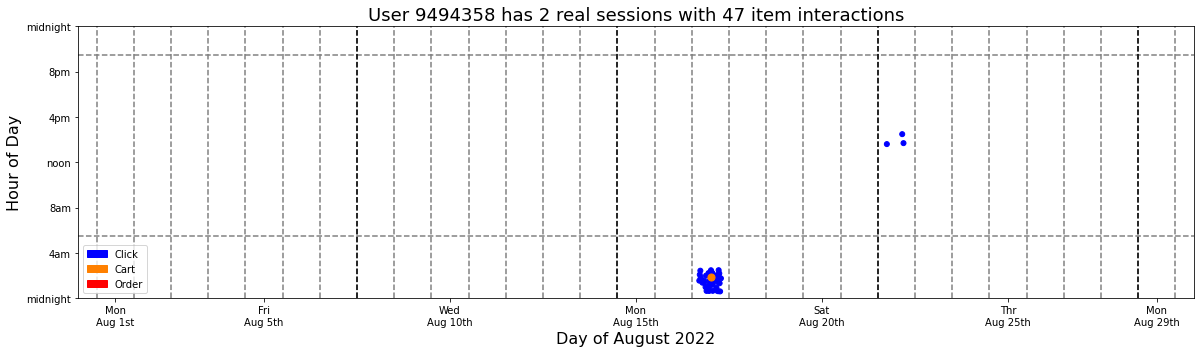

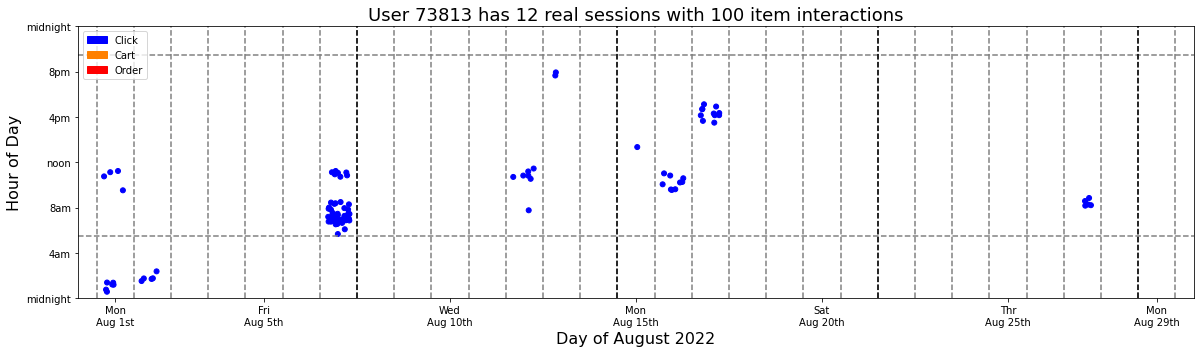

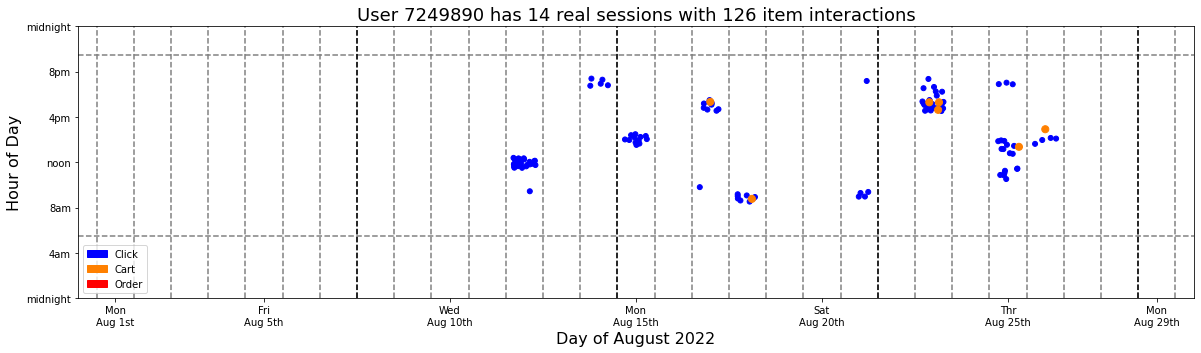

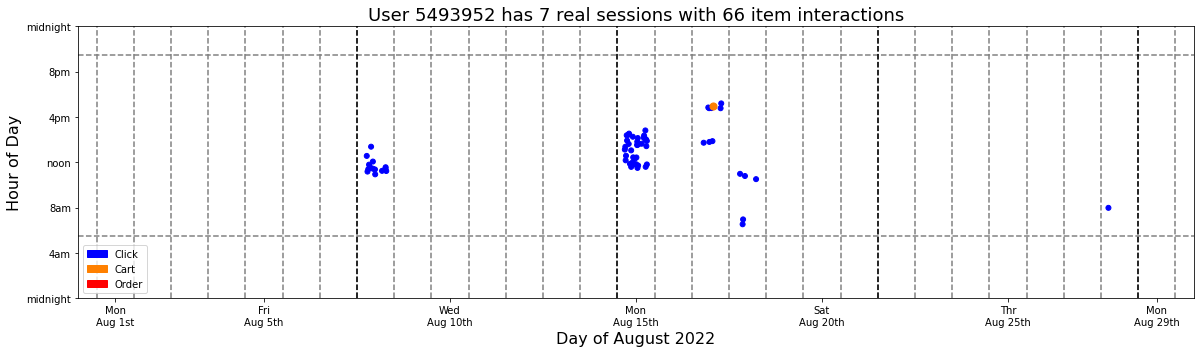

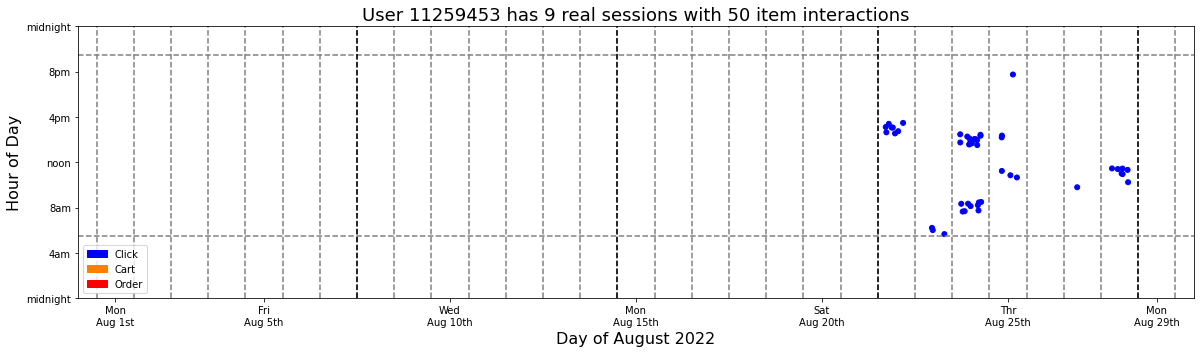

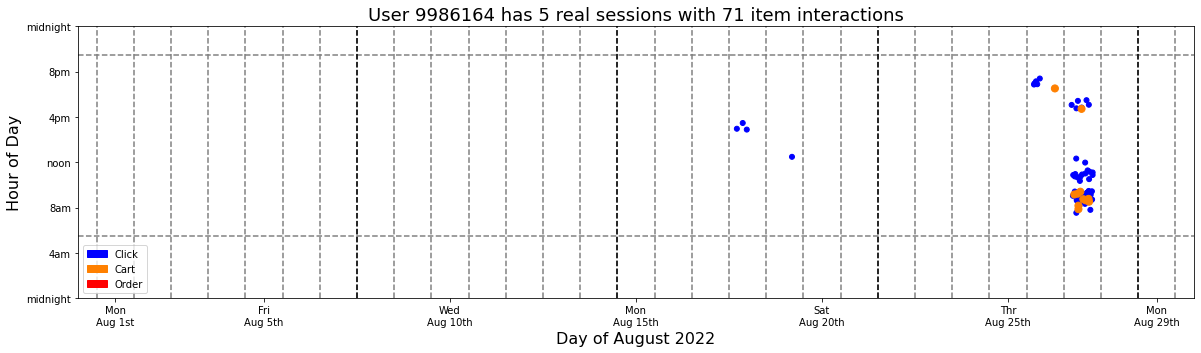

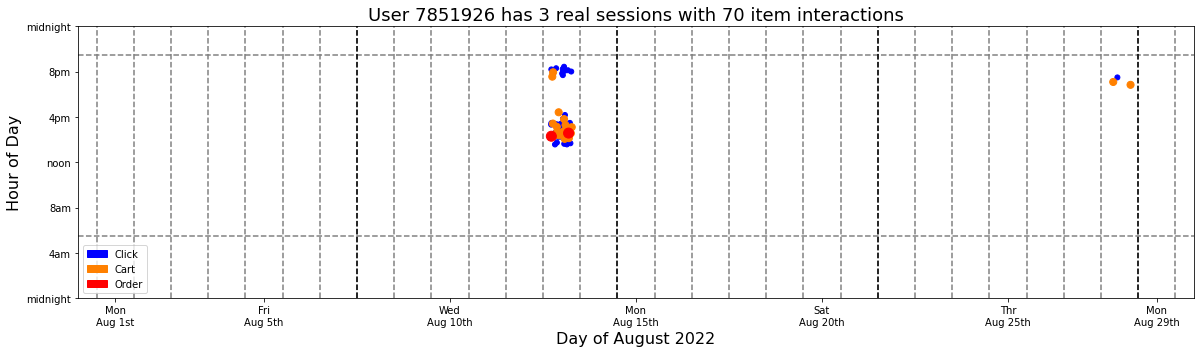

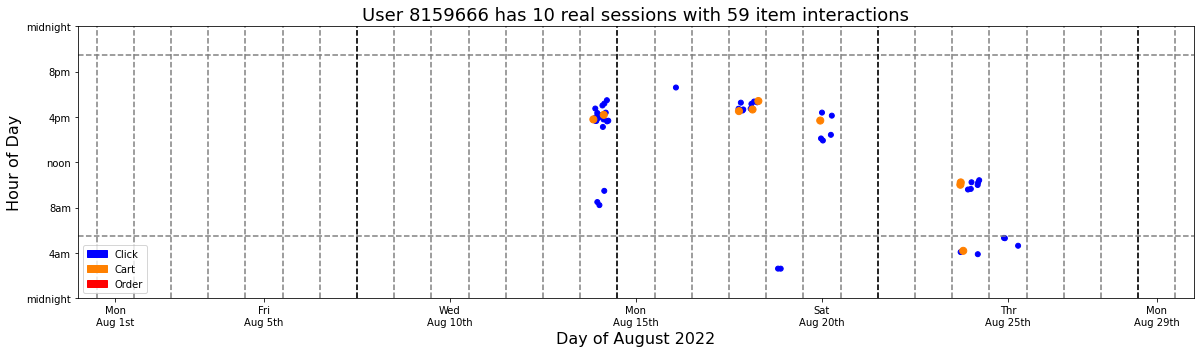

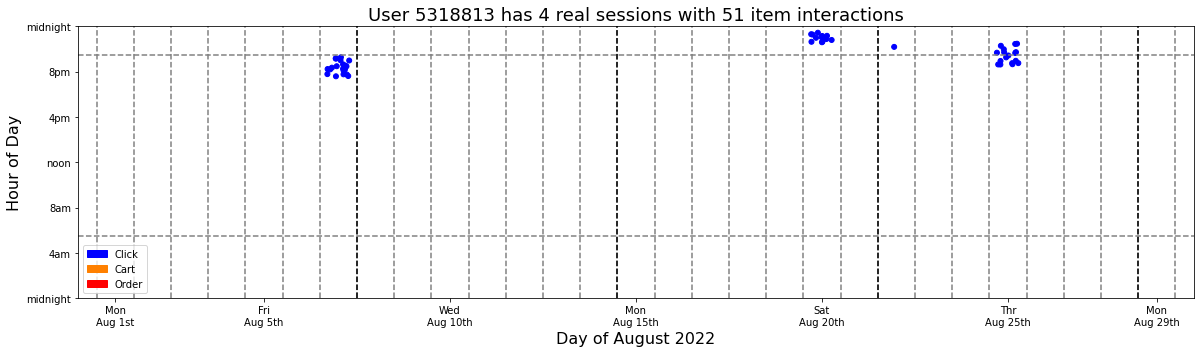

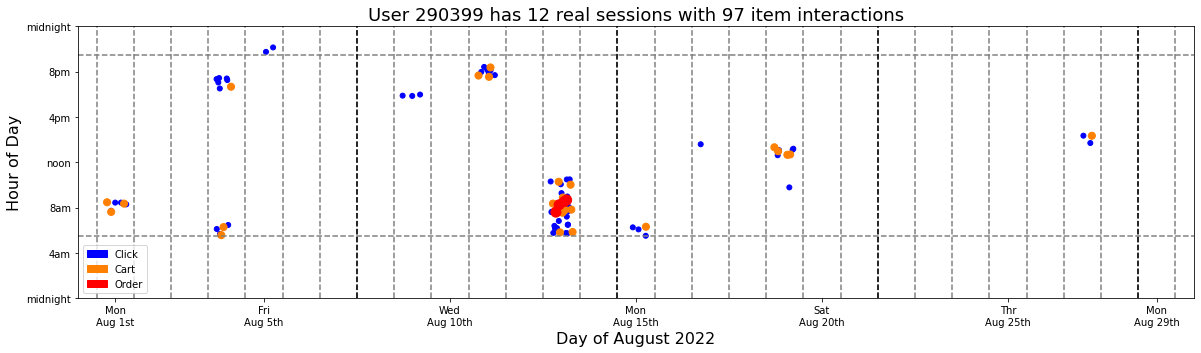

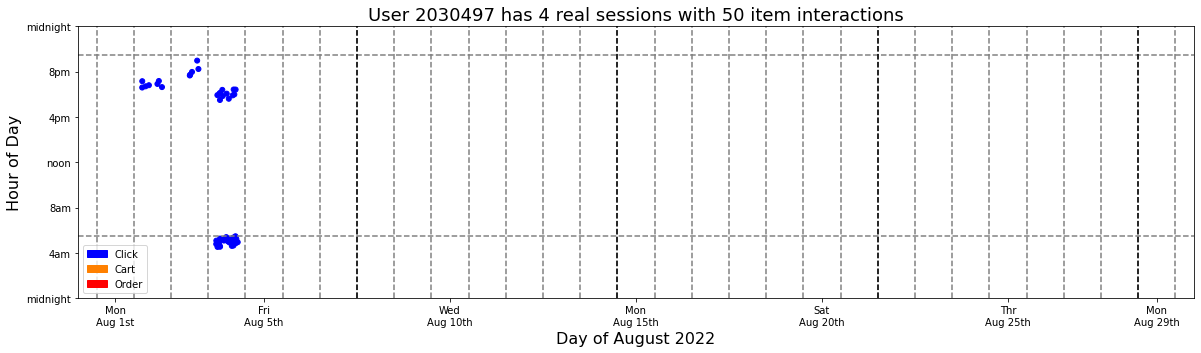

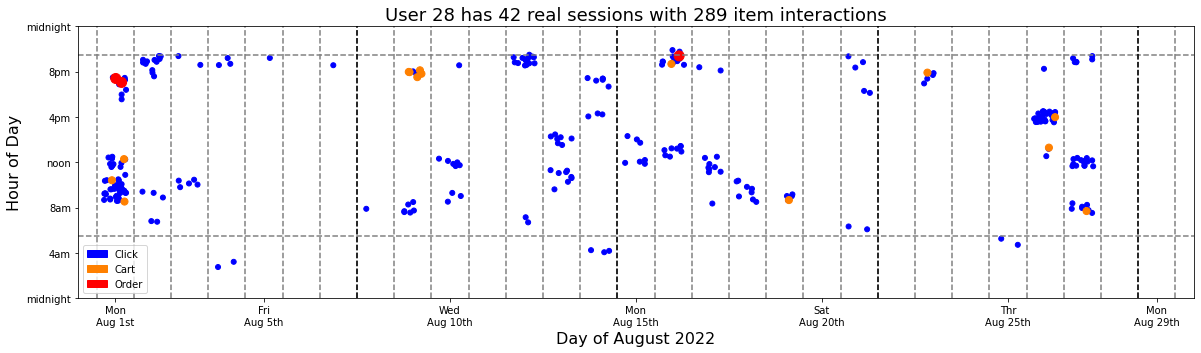

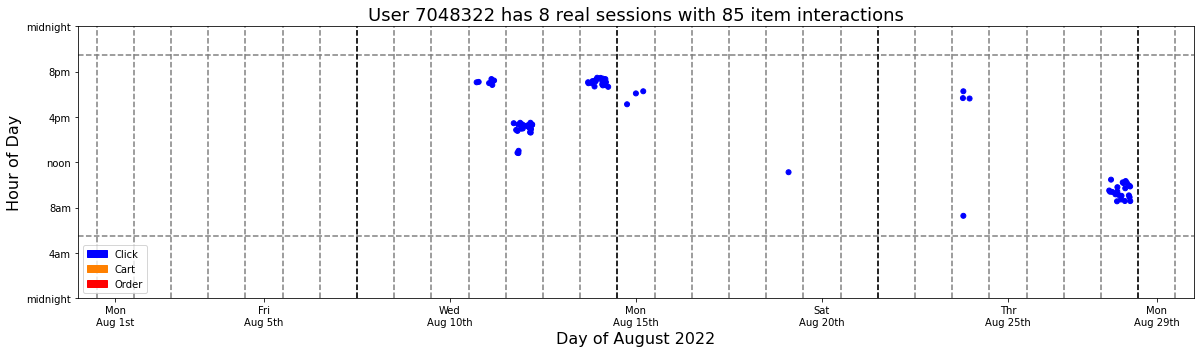

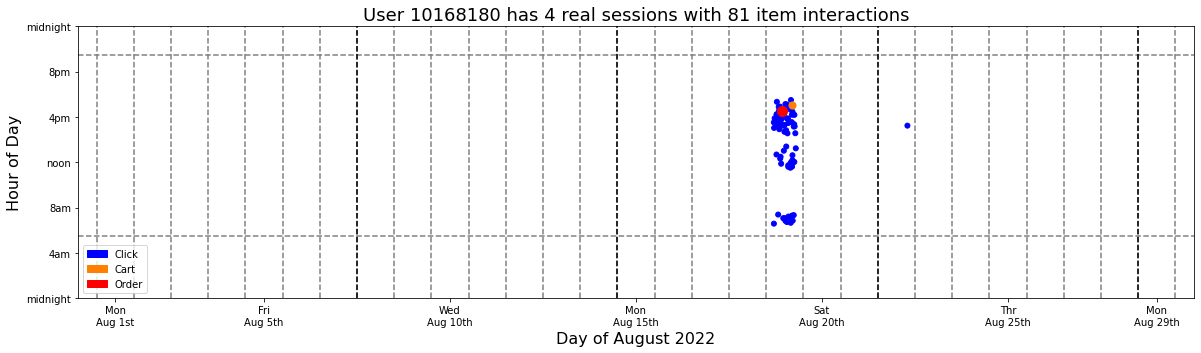

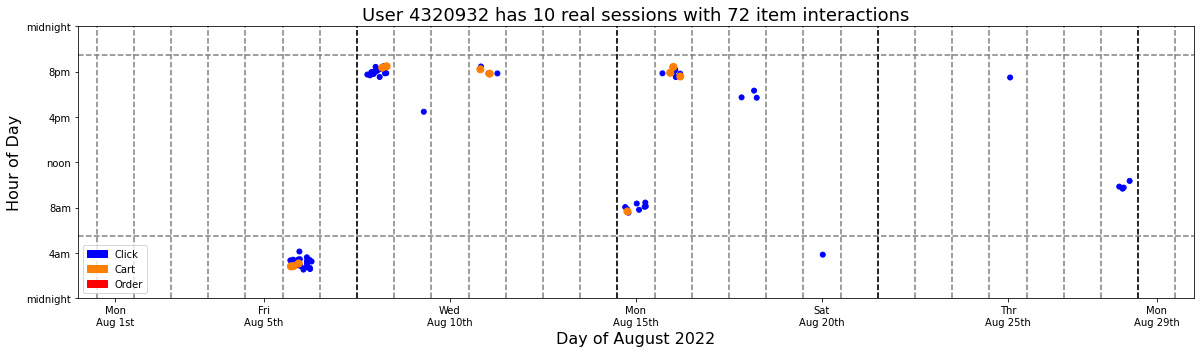

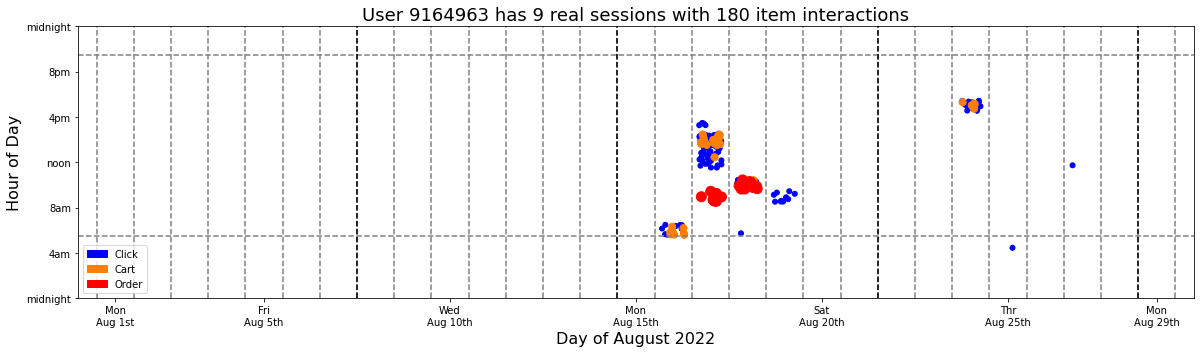

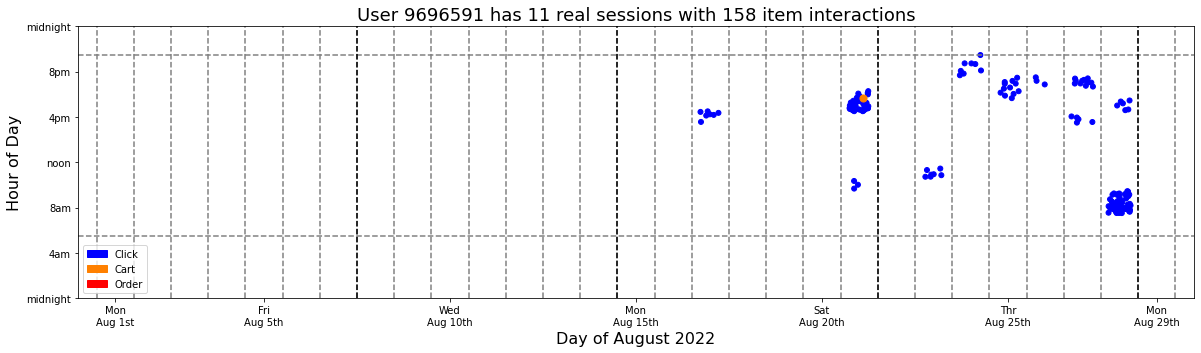

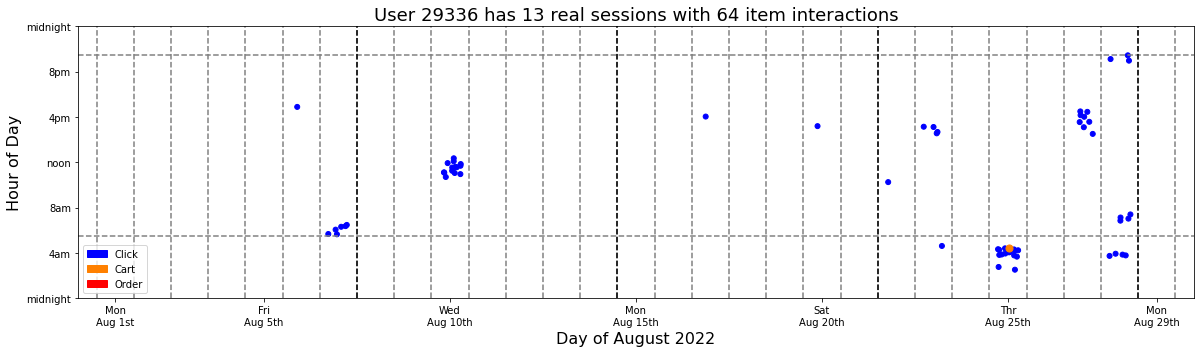

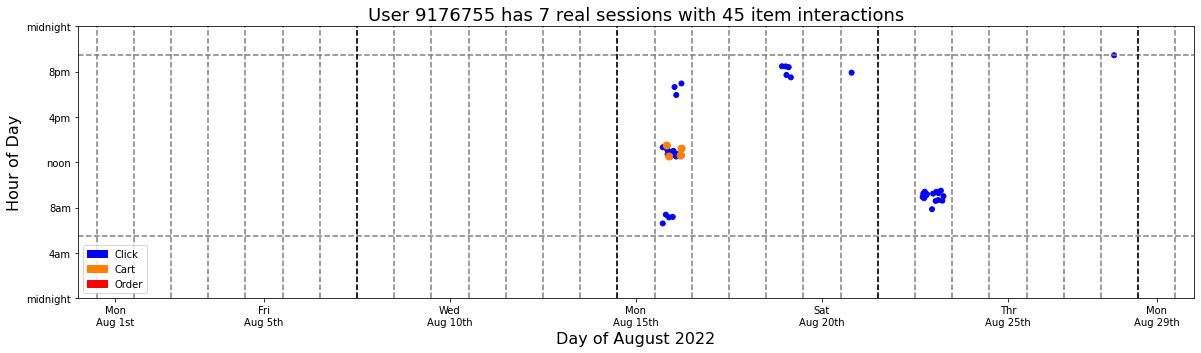

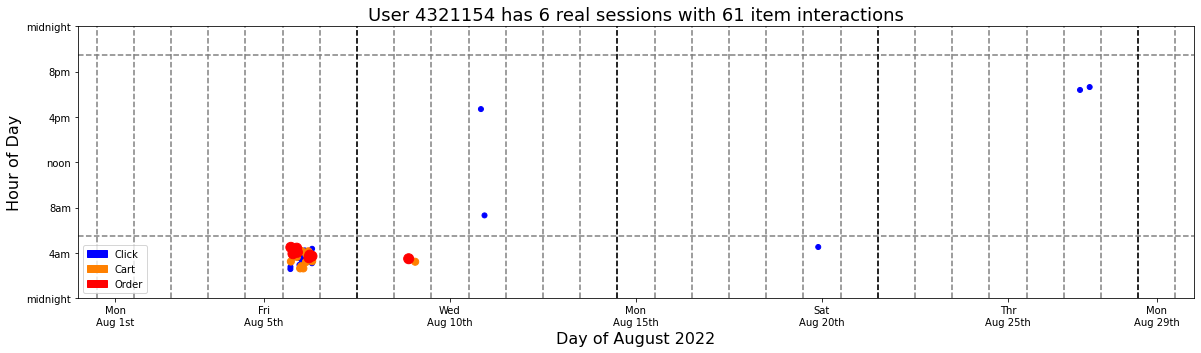

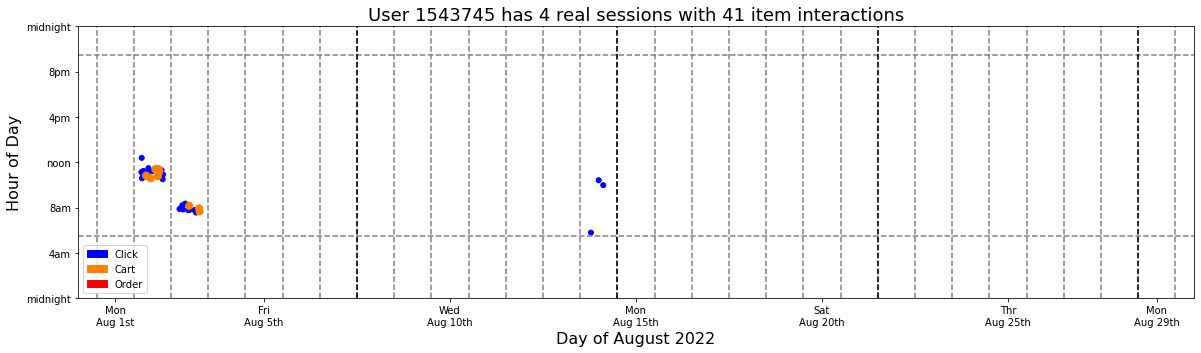

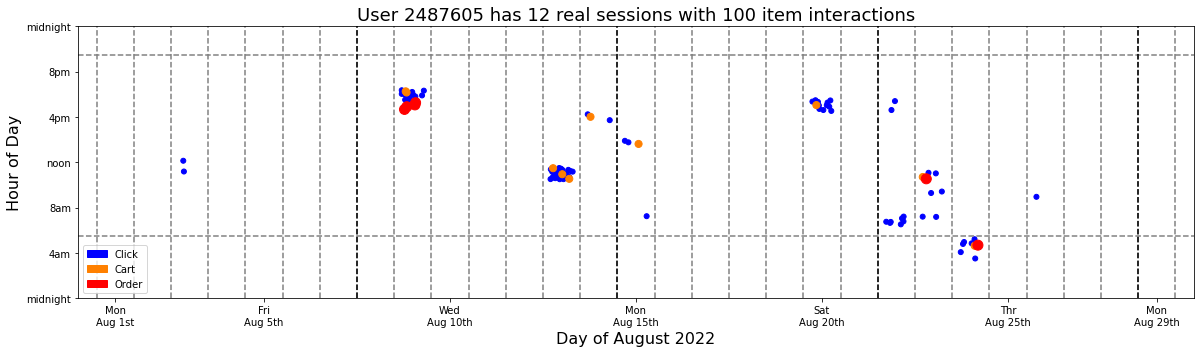

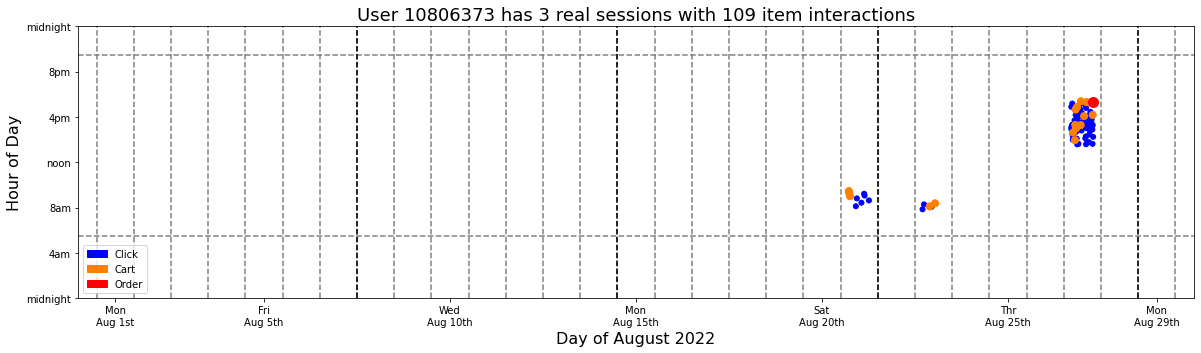

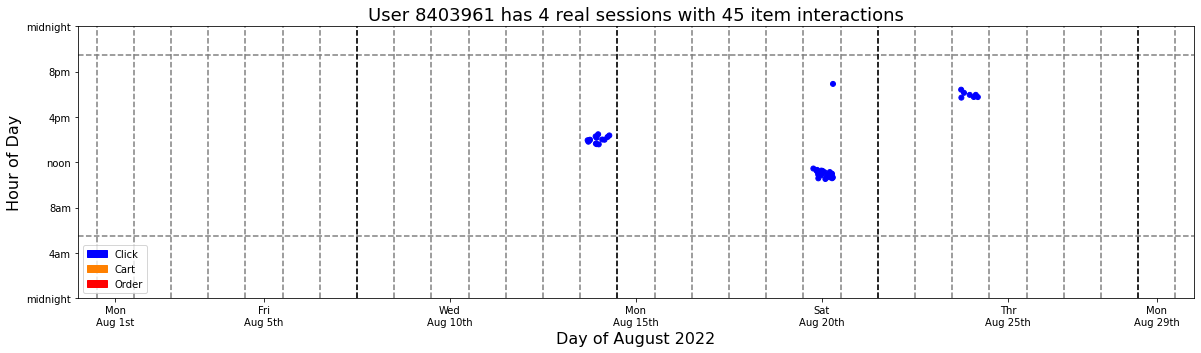

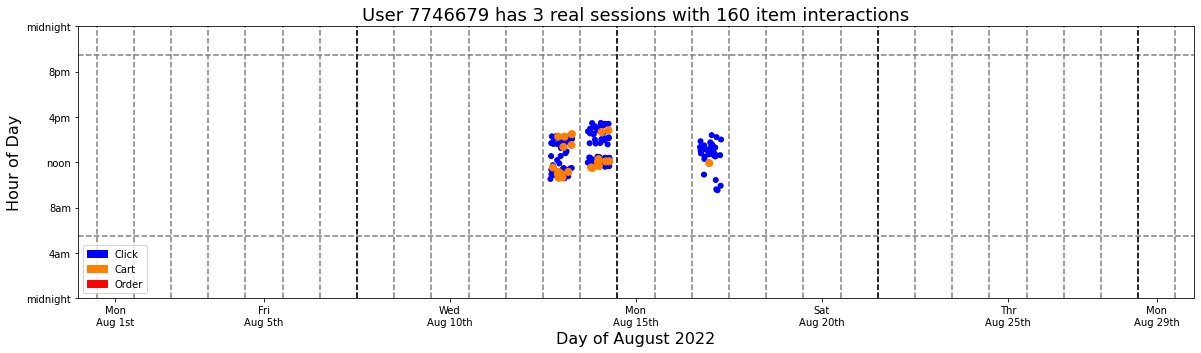

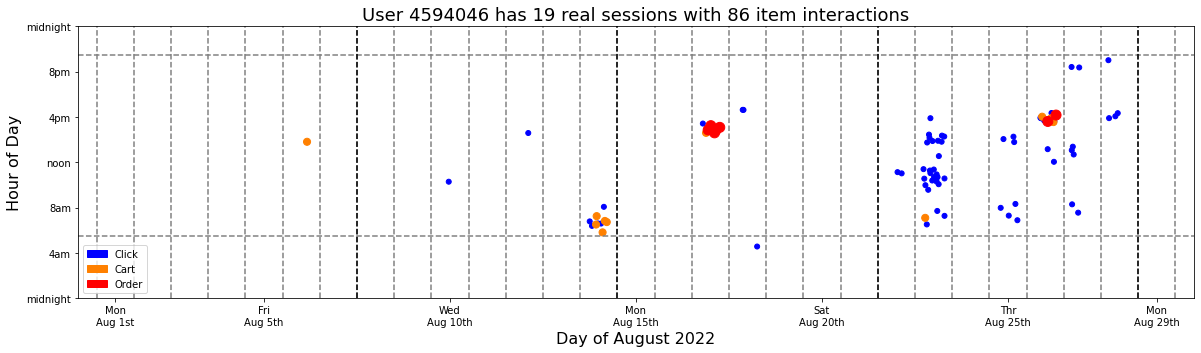

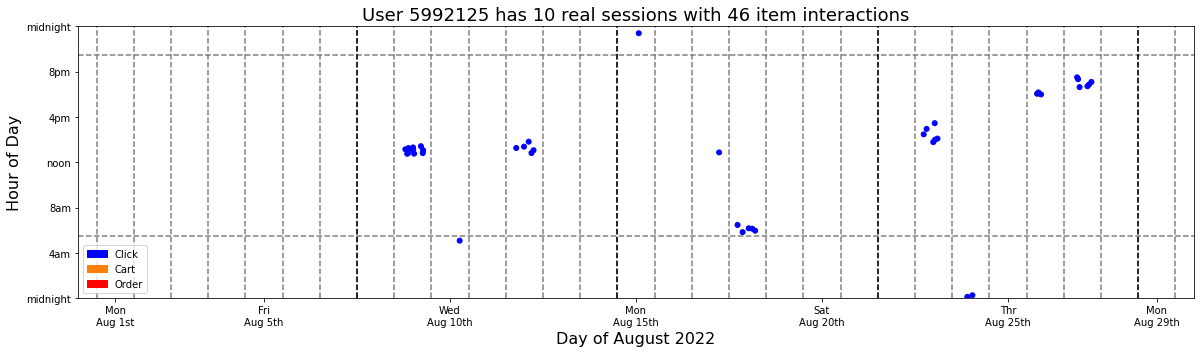

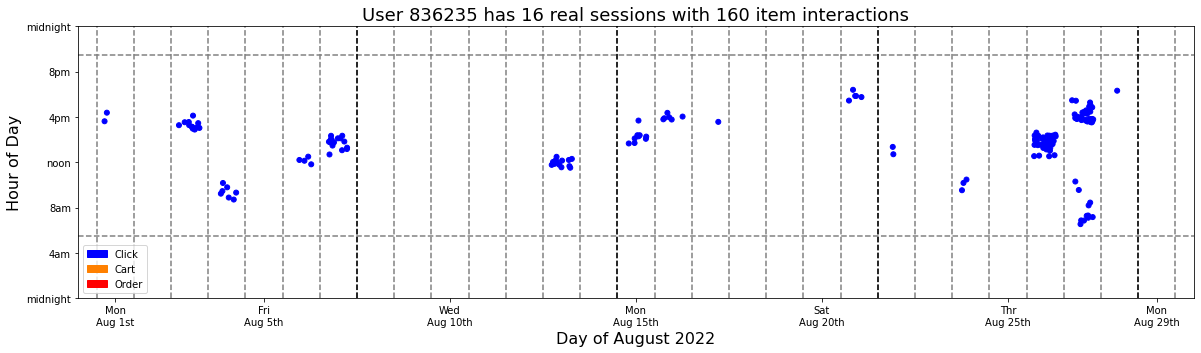

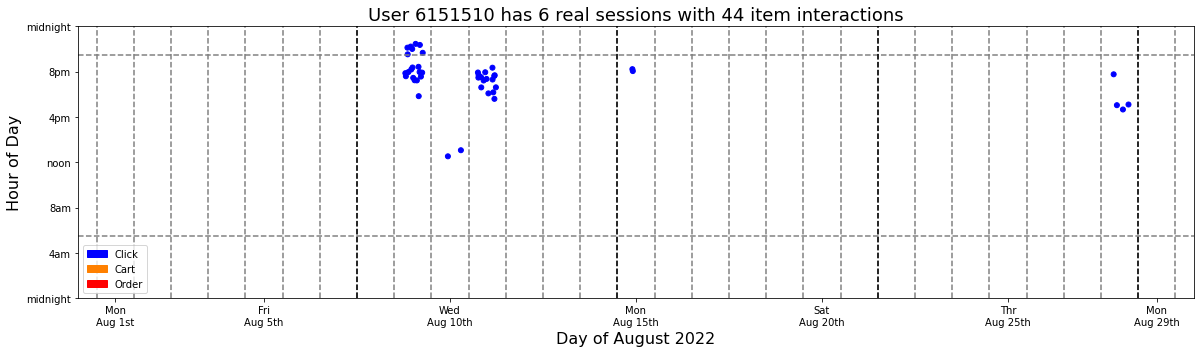

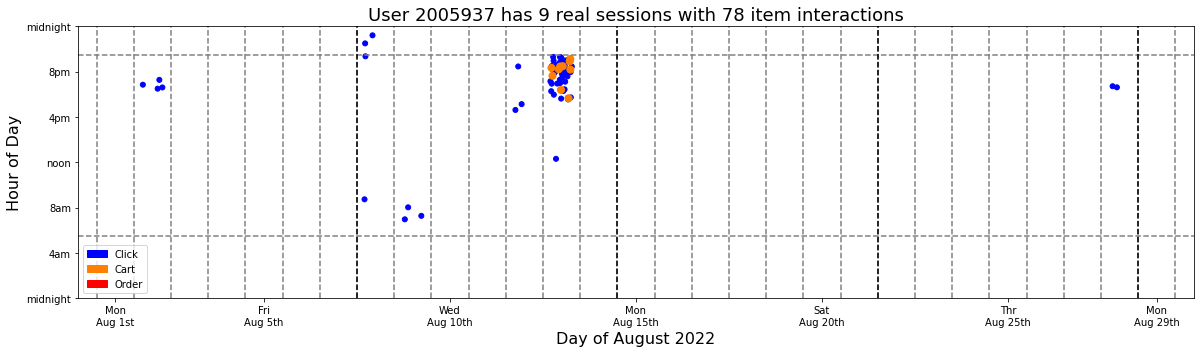

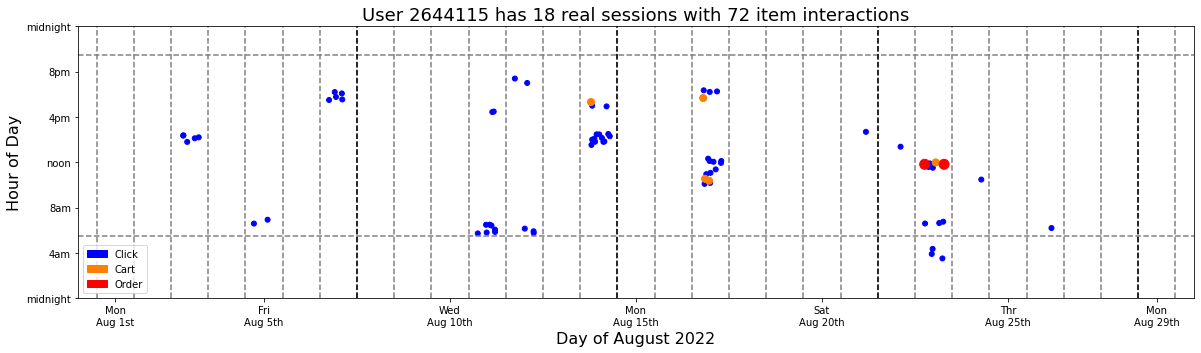

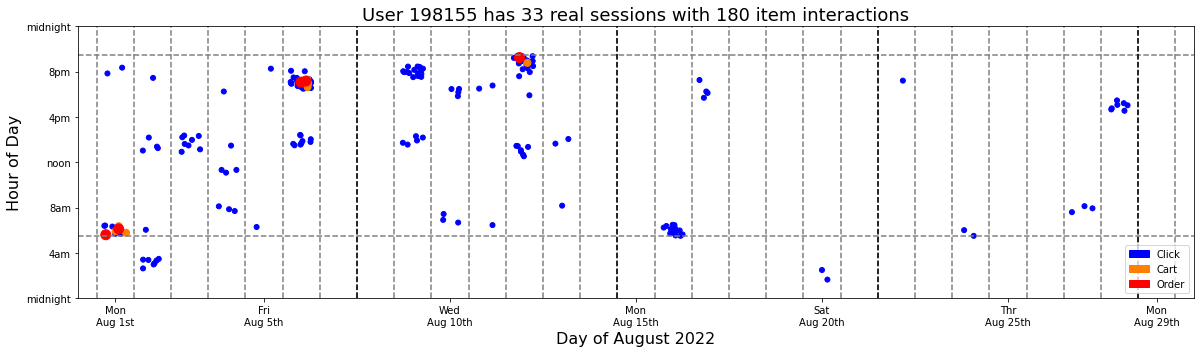

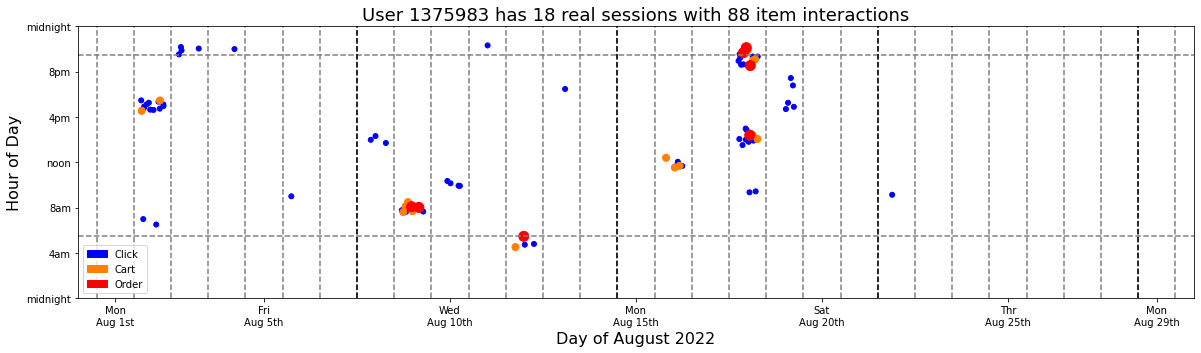

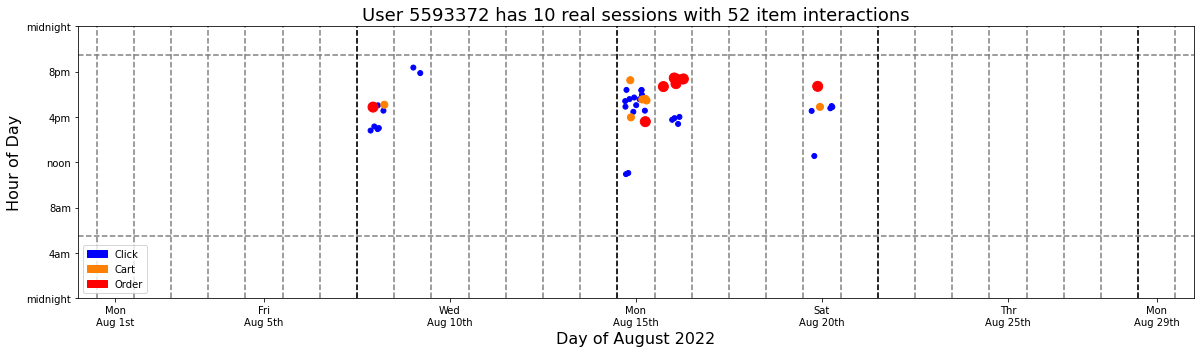

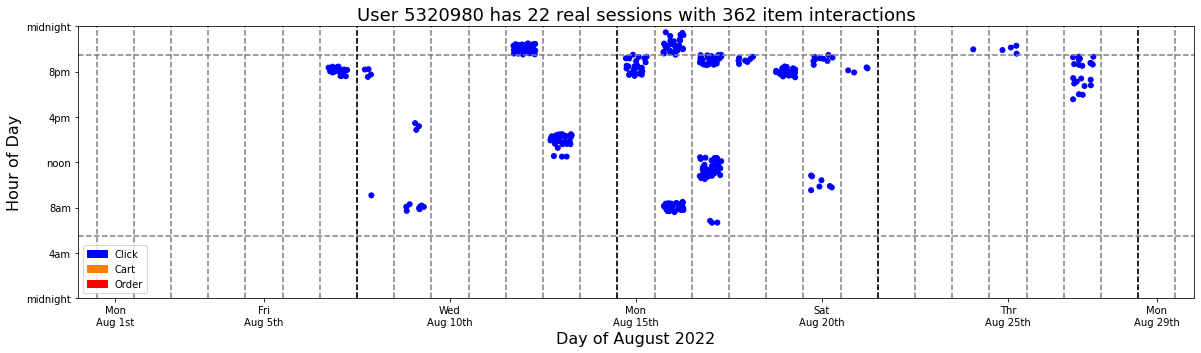

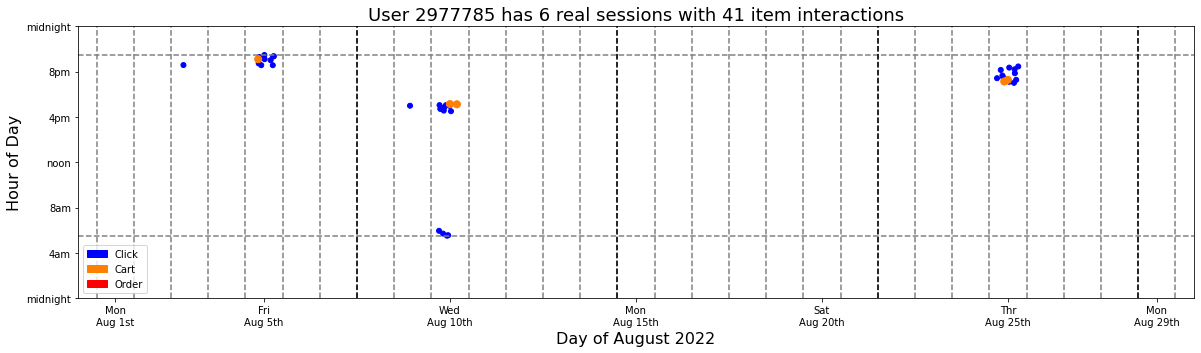

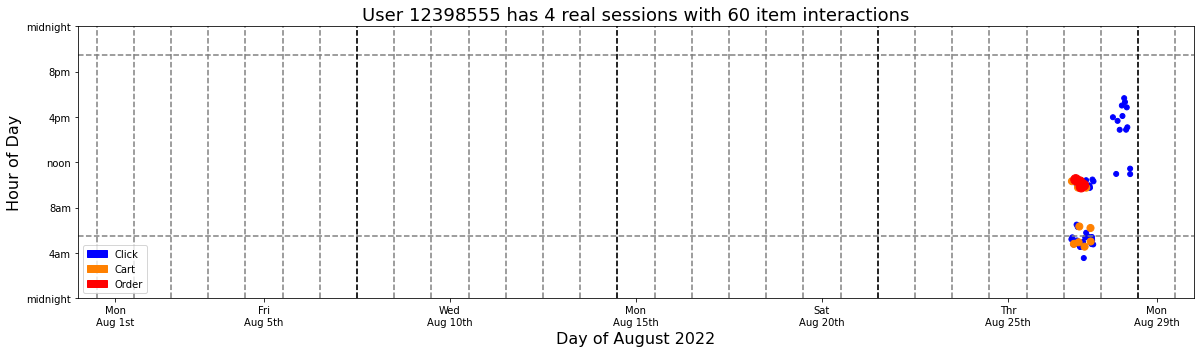

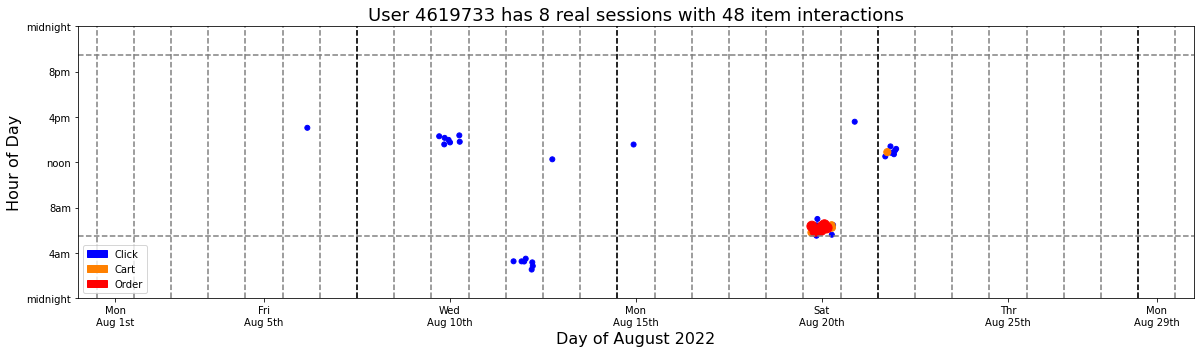

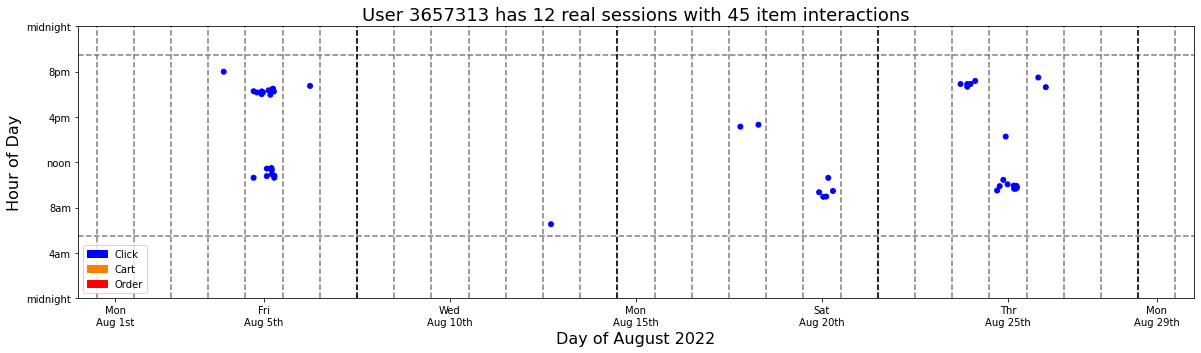

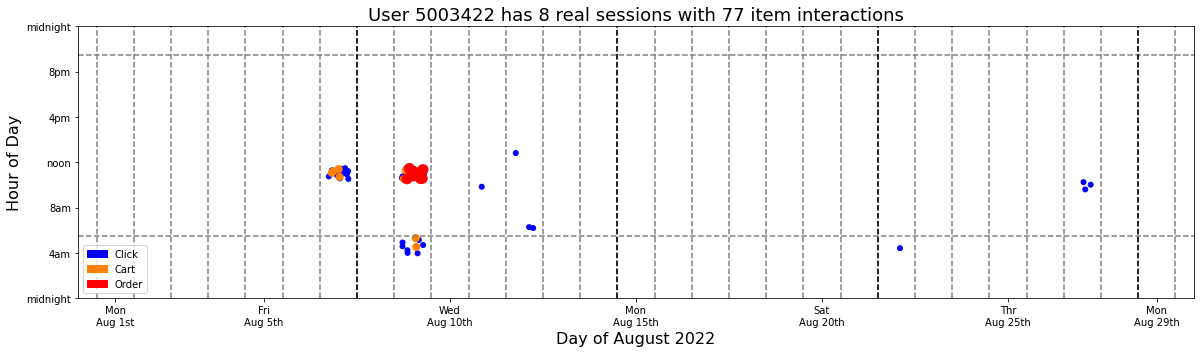

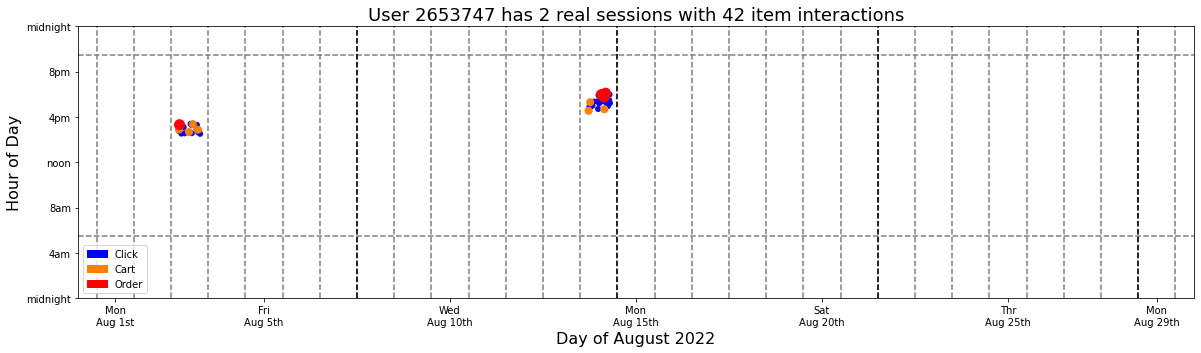

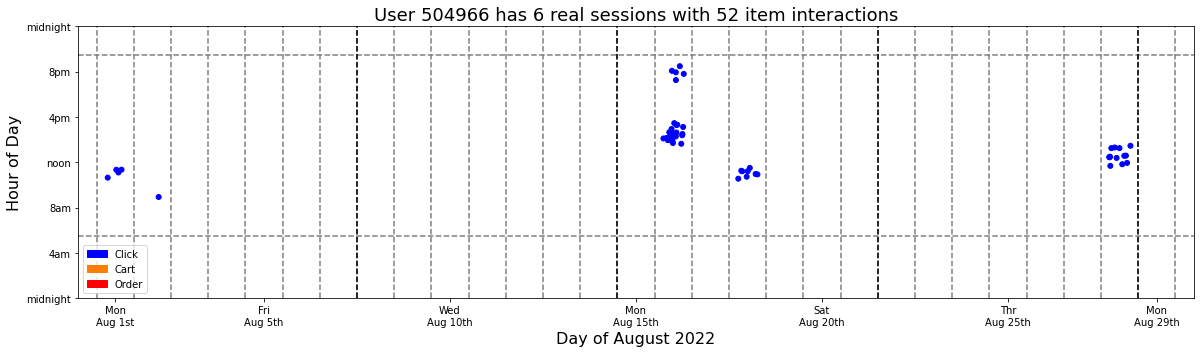

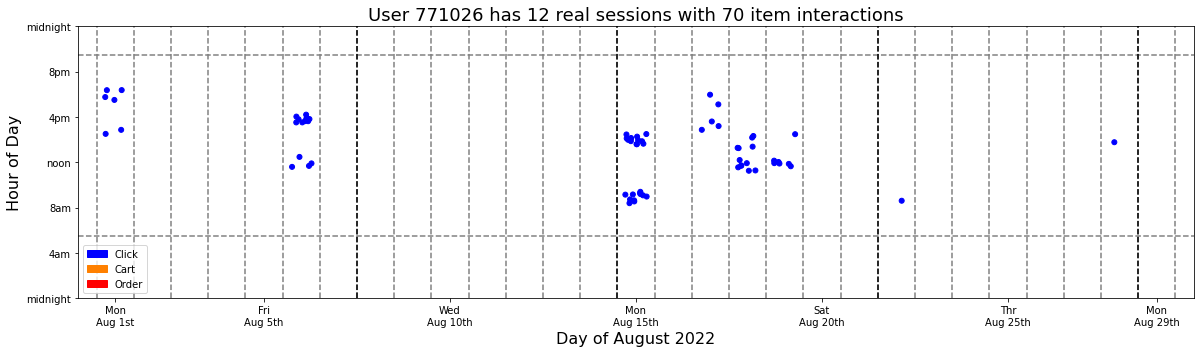

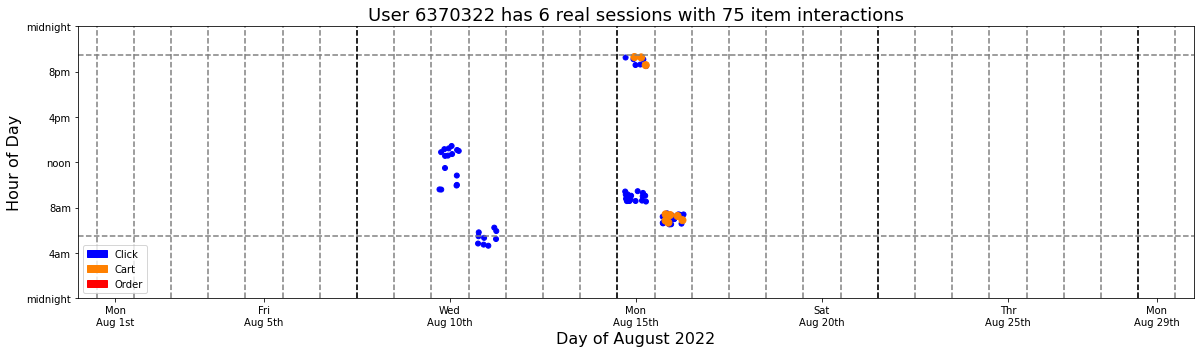

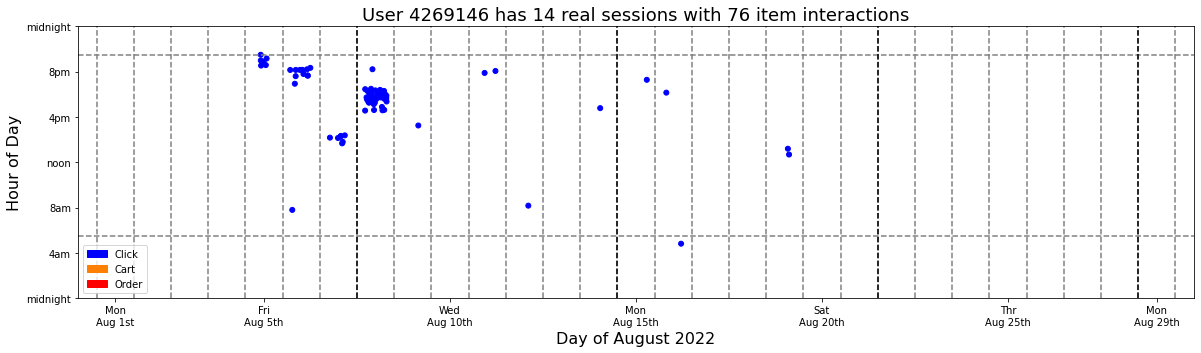

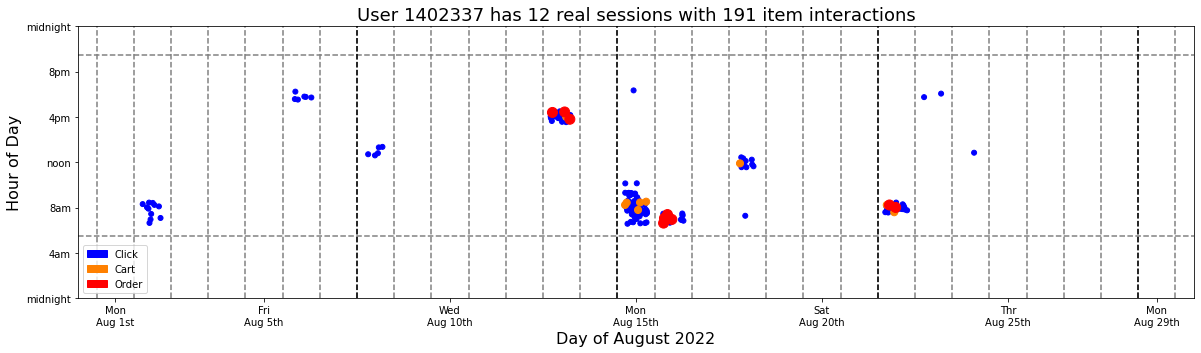

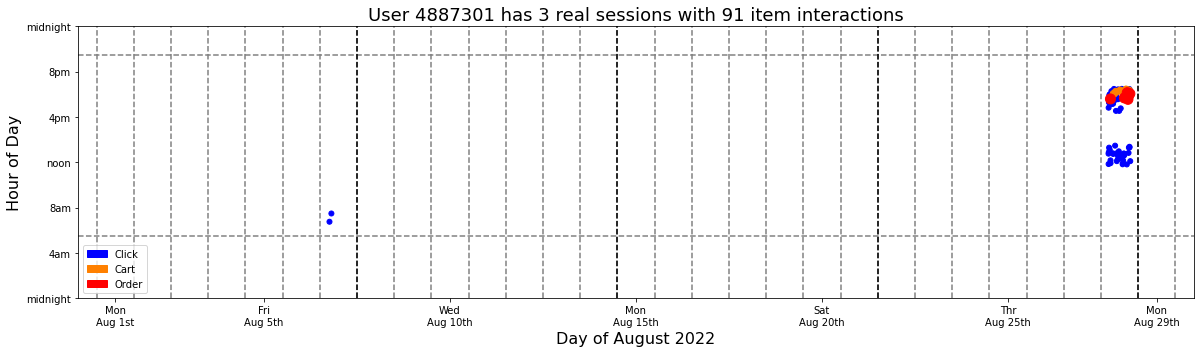

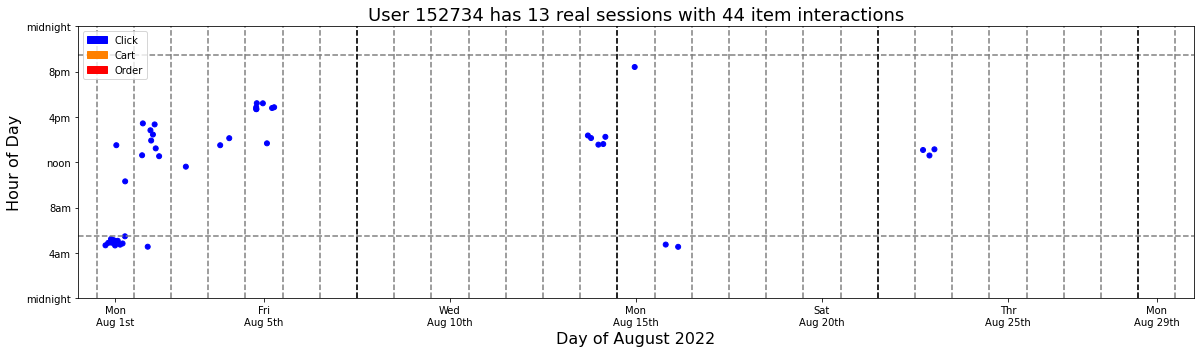

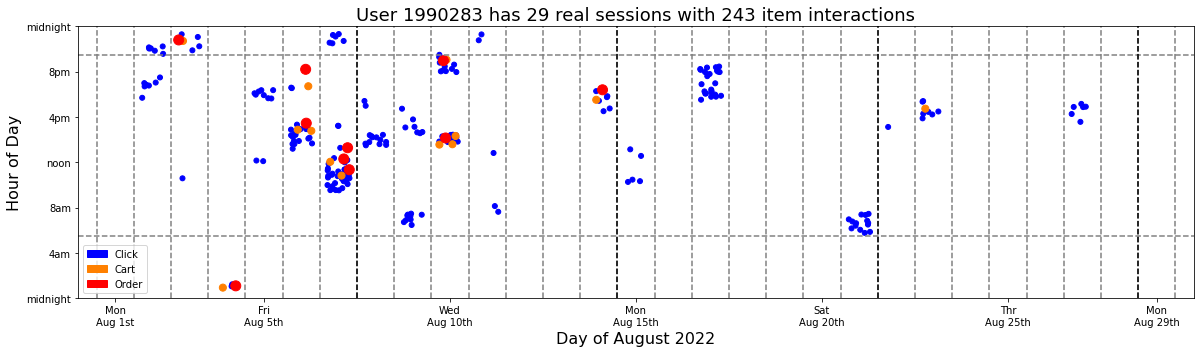

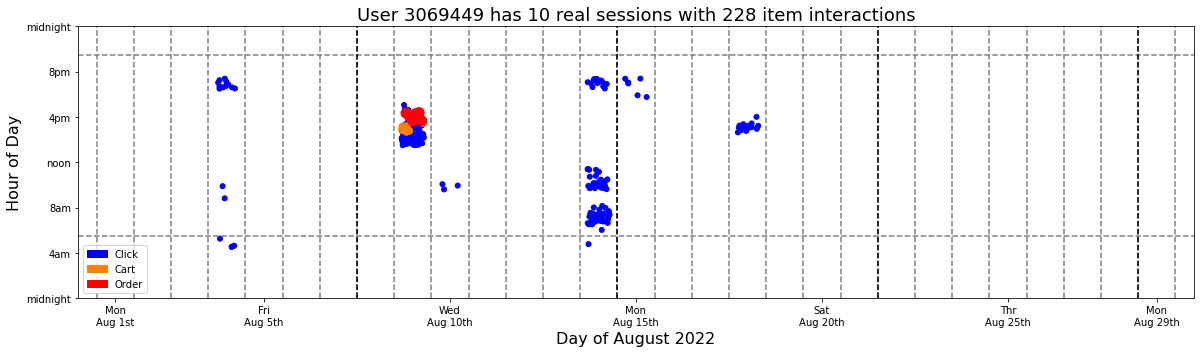

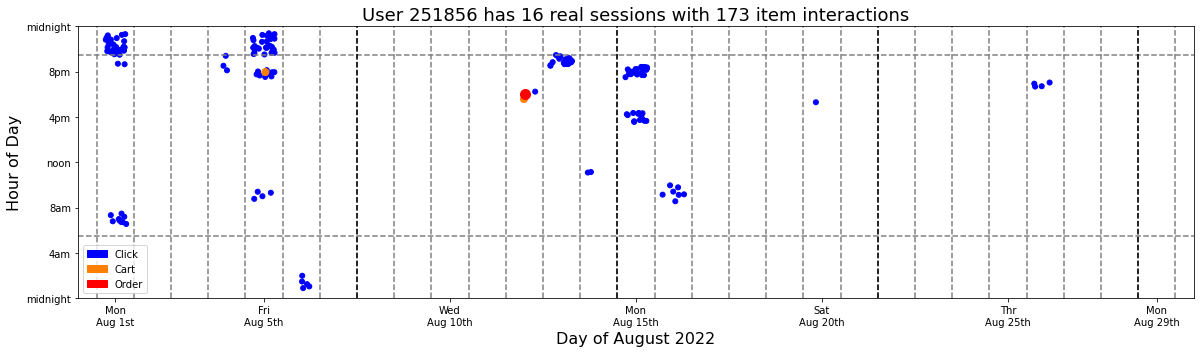

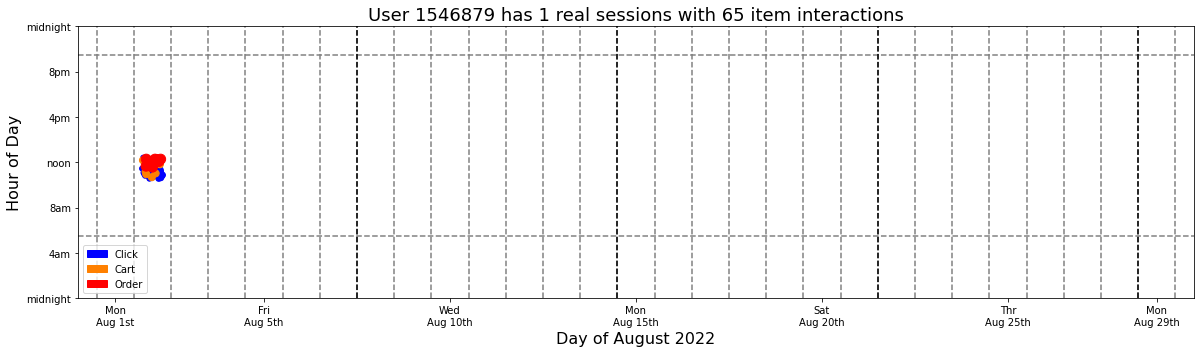

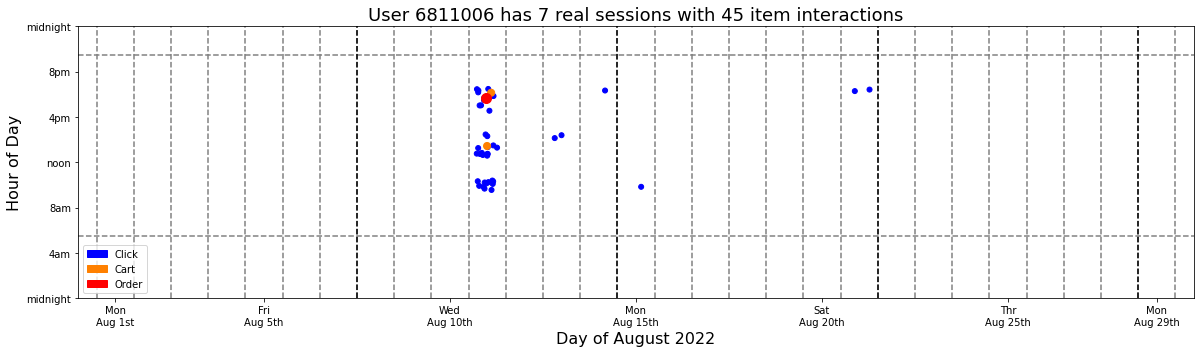

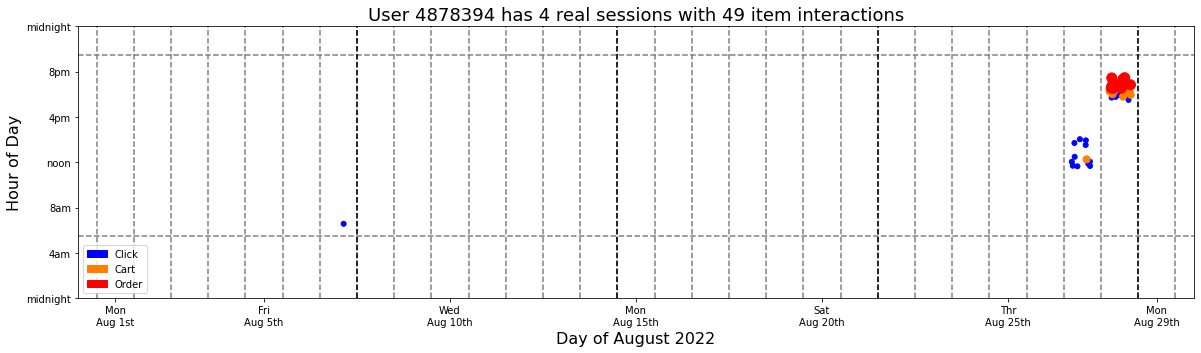

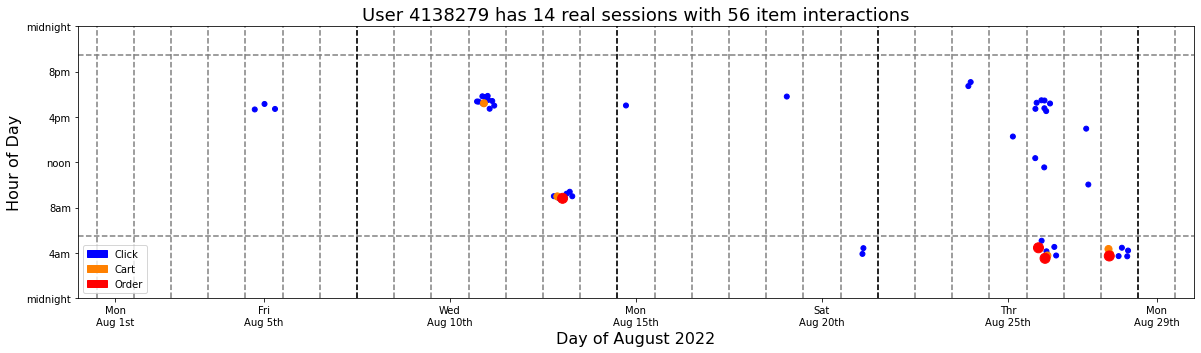

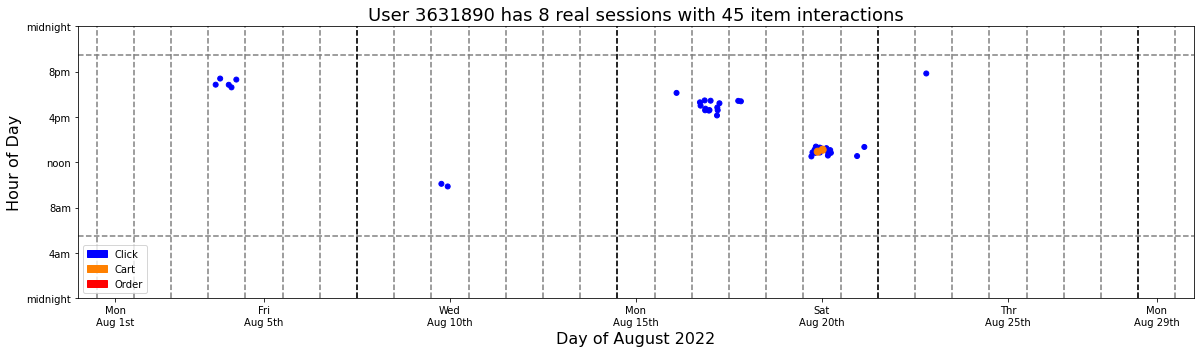

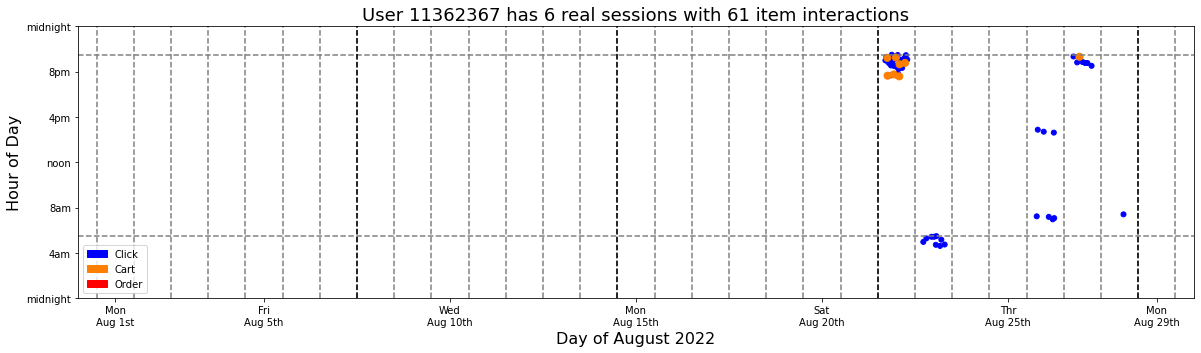

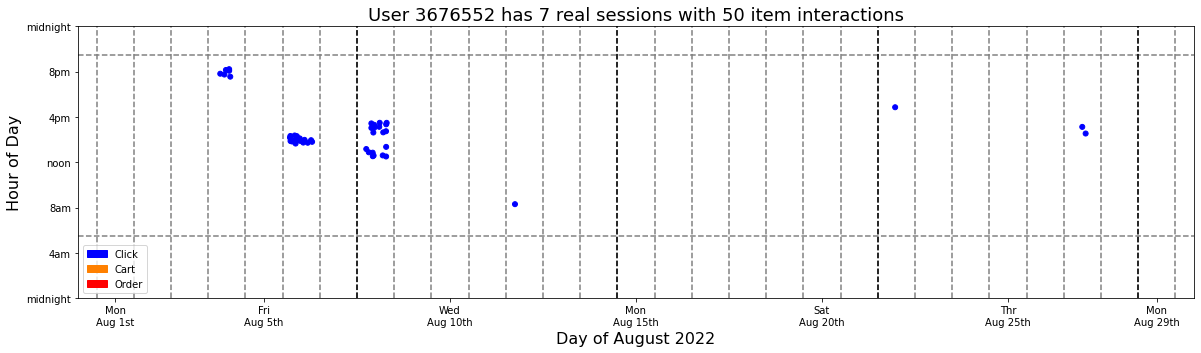

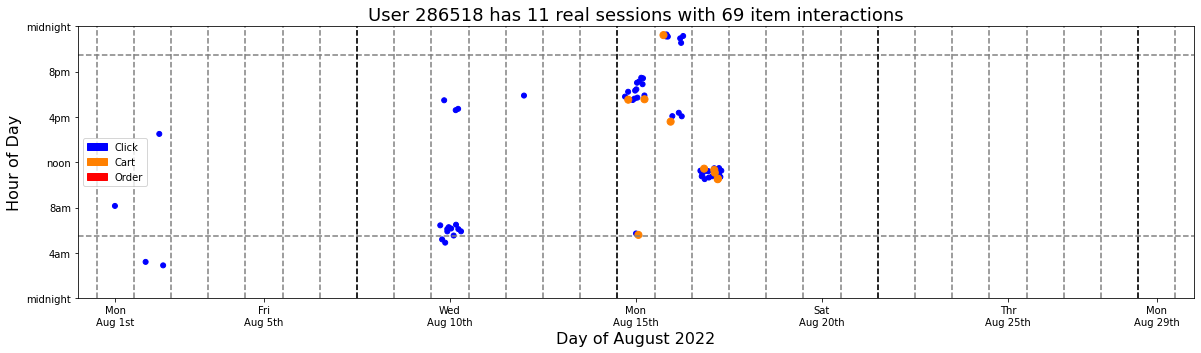

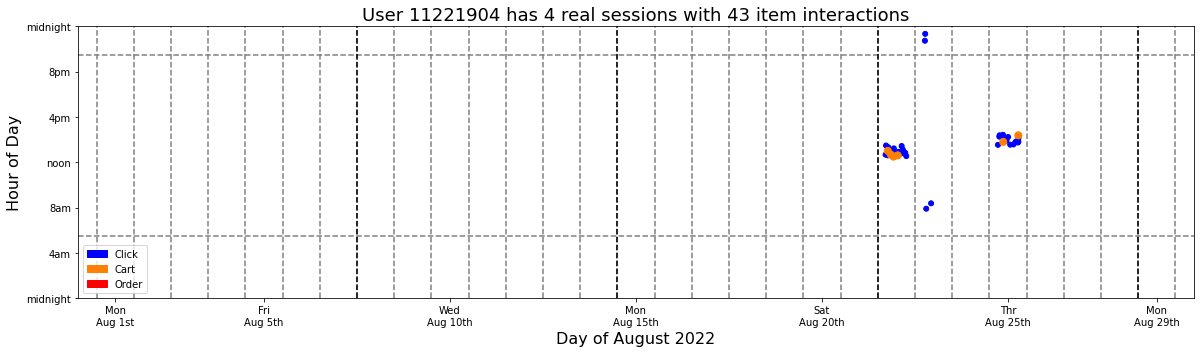

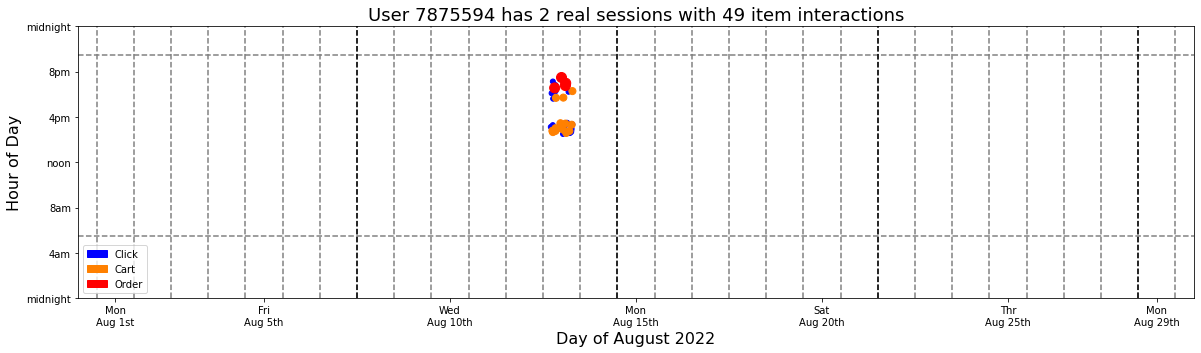

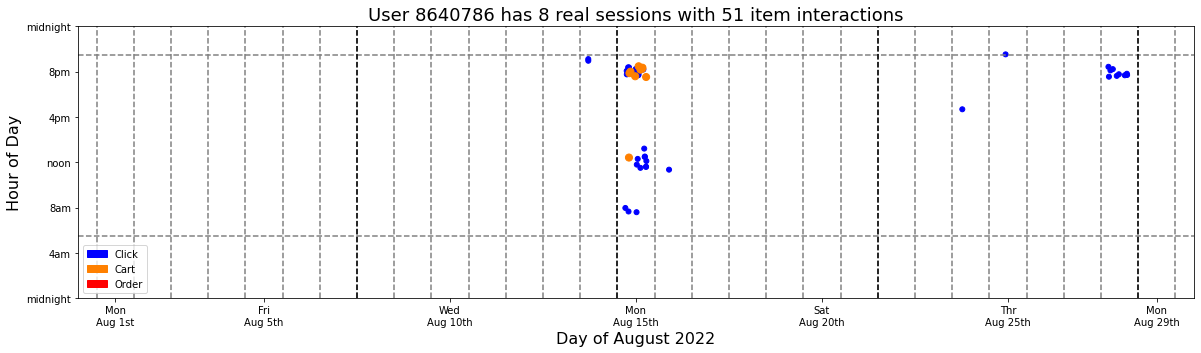

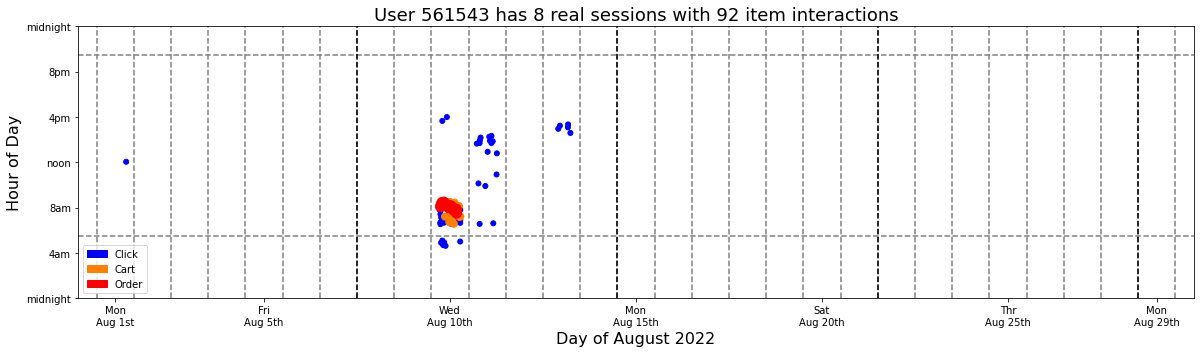

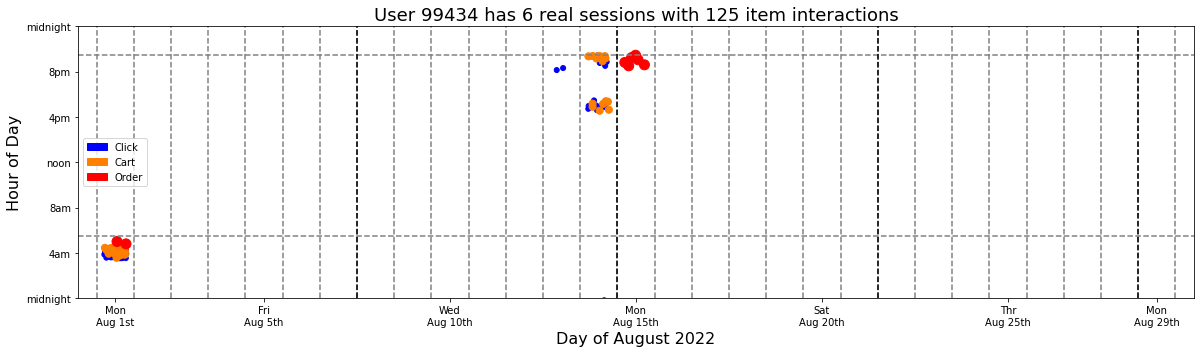

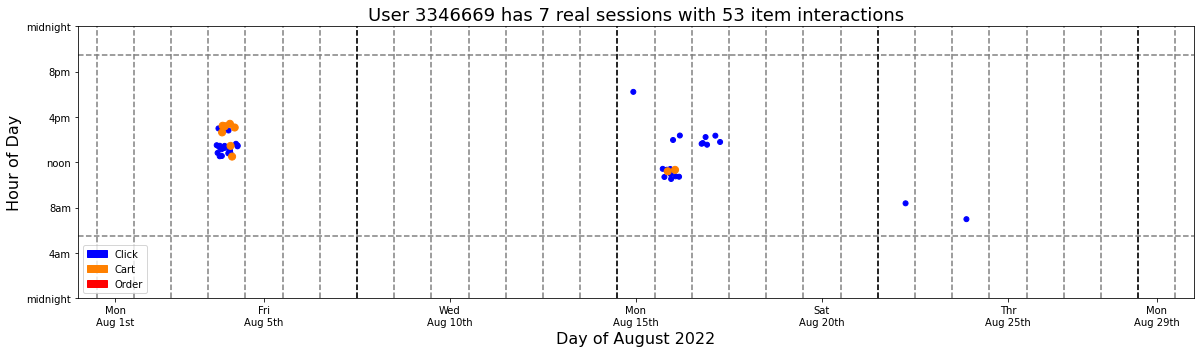

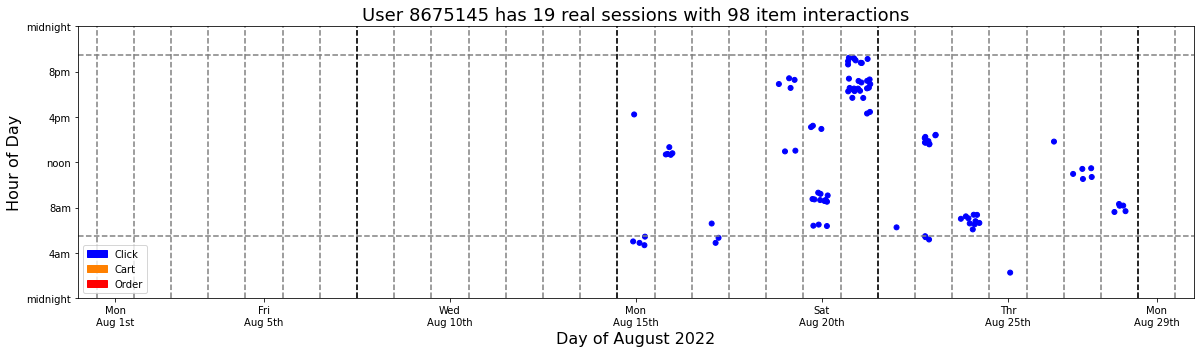

In [7]:
# DISPLAY USER ACTIVITY
colors = np.array( [(0,0,1),(1,0.5,0),(1,0,0)] )

for k in range(128):
    u = np.random.choice(frequent_users)
    tmp = train.loc[train.session==u].to_pandas()
    
    ss = tmp.d.max()+1
    ii = len(tmp)
    
    plt.figure(figsize=(20,5))
    for j in [0,1,2]:
        s = 25
        if j==1: s=50
        elif j==2: s=100
        tmp2 = tmp.loc[tmp['type']==j]
        xx = np.random.uniform(-0.3,0.3,len(tmp2))
        yy = np.random.uniform(-0.5,0.5,len(tmp2))
        plt.scatter(tmp2.day.values+xx, tmp2.hour.values+yy, s=s, c=colors[tmp2['type'].values])
    plt.ylim((0,24))
    plt.xlim((0,30))
    c1 = mpatches.Patch(color=colors[0], label='Click')
    c2 = mpatches.Patch(color=colors[1], label='Cart')
    c3 = mpatches.Patch(color=colors[2], label='Order')
    plt.plot([0,30],[6-0.5,6-0.5],'--',color='gray')
    plt.plot([0,30],[21+0.5,21+0.5],'--',color='gray')
    for k in range(0,30):
        plt.plot([k+0.5,k+0.5],[0,24],'--',color='gray')
    for k in range(1,5):
        plt.plot([7*k+0.5,7*k+0.5],[0,24],'--',color='black')
    plt.legend(handles=[c1,c2,c3])
    plt.xlabel('Day of August 2022',size=16)
    plt.xticks([1,5,10,15,20,25,29],['Mon\nAug 1st','Fri\nAug 5th','Wed\nAug 10th','Mon\nAug 15th','Sat\nAug 20th','Thr\nAug 25th','Mon\nAug 29th'])
    plt.ylabel('Hour of Day',size=16)
    plt.yticks([0,4,8,12,16,20,24],['midnight','4am','8am','noon','4pm','8pm','midnight'])
    plt.title(f'User {u} has {ss} real sessions with {ii} item interactions',size=18)
    plt.show()
    print('\n\n')

# Observations
We observe many patterns above. Most users exhibit regular behavior. They `click`, `cart` and `order` at the same hours each day. Also most users like to shop on the same days of the each week. Most users are active during the waking hours of day but some users like to shop during the night while others are sleeping. We also notice that users shop in clusters of activity. Our challenge in this competition is that we must both predict the remainder of the last cluster (provided in test data) and predict new clusters (after last timestamp in test). Furthermore all users in test data (not displayed in this notebook) have less than 1 week data, so we must predict user behavior given little user history information (i.e. the RecSys "cold start" problem). Understanding users and their behavior will help us predict test users' future behavior!